In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.metrics.pairwise import rbf_kernel
import cvxopt
from sklearn.metrics.pairwise import rbf_kernel
from matplotlib.colors import ListedColormap
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Course reminder

### Motivation:

Many machine learning problems, whether they be supervised or unsupervised, write as follows:

\begin{equation*}
\min_{f\in \mathcal{F}} \frac{1}{n}\sum_{i=1}^n \ell(f(x_i)) + \lambda \Omega(f)
\end{equation*}

for some hypothesis space $\mathcal{F}$ and some regularization $\Omega$.

Kernel methods allow to manipulate hypothesis spaces that are not only Hilbert Spaces but also enjoy the so-called reproducing property. 

### Kernels and RKHS:

As seen in the lecture, let us define a positive definite symmetric kernel $k : \mathbb{R}^d \times \mathbb{R}^d \mapsto \mathbb{R}$. 
Denote $\mathcal{H}_k$ its associated Reproducing Kernel Hilbert space ($\mathcal{H}$, $\langle \cdot, \cdot \rangle_{\mathcal{H}_k}$).

Let us recall that the following properties: for any $x\in \mathbb{R}^d$, we have:

$k(\cdot, x) \in \mathcal{H}_k$ \\
for any $f \in \mathcal{H}_k$,~$f(x) = \langle f, k(\cdot,x) \rangle_{\mathcal{H}_k}$ 

In praticular, $k(x,z) = \langle k(\cdot, x), k(\cdot, z) \rangle_{\mathcal{H}_k}$ 

In the remaining part of the document, we use refer to $k(\cdot, x)$ as the canonical feature map defined as:      
\begin{equation*}
\phi(x) = k(\cdot, x)
\end{equation*}

Learning within RKHSs means that we choose as hypothesis space this functional space. An interesting choice for $k$ is to pick up the Gaussian kernel:
    \begin{equation*}
    k(x,z)= \exp(-\gamma \| x - z\|^2).
    \end{equation*}
    
Indeed, the Gaussian kernel is said to be universal, i.e. the associated RKHS $\mathcal{H}_k$ is dense into the space of continuous real-valued functions.



# I. Basic kernel manipulations

Notations:

- $x_1,\ldots,x_n$ are the training point in $\mathbb{R}^d$. 
- The matrix $X$ is defined as $X = [x_1^T,...,x_n^T]$
- Similarly $z_1,...,z_m$ are the test points and $Z = [z_1^T,...,z_m^T]$
- We denote $K^{xx}$ the gram matrix of the train set that is $K^{xx}_{i,j} = k(x_i,x_j)$. When there is no ambiguity we simply denote it $K$.
- We denote $K^{xz}$ the train/test product matrix that is $K^{xz}_{i,j} = k(x_i,z_j)$

Q1) Prove that the linear kernel is a kernel 

$$k(x,y) = \langle x, y \rangle$$

The most popular/common kernel is the gaussian kernel 

$$k(x,y) = \exp\left(-\frac{||x-y||_2^2}{\sigma^2}\right)$$

<span style="color:cyan">

Pour prouver que le noyau linéaire $k(x,y) = \langle x, y \rangle$ est un noyau, nous devons vérifier qu'il s'agit d'une fonction symétrique et définie positive.

**Symétrie:** Pour tout $x, y \in \mathbb{R}^d$, nous avons:
\begin{align}
k(x,y) &= \langle x, y \rangle \\
&= \langle y, x \rangle \\
&= k(y,x)
\end{align}
où l'égalité du milieu vient de la symétrie du produit scalaire.

**Définie positive:** Pour tout ensemble fini de points $\{x_1, \ldots, x_n\} \subset \mathbb{R}^d$ et pour tout $\alpha_1, \ldots, \alpha_n \in \mathbb{R}$, nous devons montrer que:
\begin{align}
\sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j k(x_i, x_j) \geq 0
\end{align}

En substituant la définition du noyau linéaire:
\begin{align}
\sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j k(x_i, x_j) &= \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j \langle x_i, x_j \rangle \\
&= \left\langle \sum_{i=1}^n \alpha_i x_i, \sum_{j=1}^n \alpha_j x_j \right\rangle \\
&= \left\| \sum_{i=1}^n \alpha_i x_i \right\|^2 \geq 0
\end{align}

Ainsi, le noyau linéaire $k(x,y) = \langle x, y \rangle$ est à la fois symétrique et défini positif, donc c'est un noyau valide.
<span>

Q2) Let us prove that this is a valid kernel as well. Assume $d=1$ and $\sigma = 1$ to simplify.

- Step 1: Prove that $k(x,y) = (xy)^k$ is a kernel
- Step 2: use that a linear combinaison of kernels is kernel to prove that $k(x,y) = \sum_{k=0}^n (xy)^k$ is a kernel
- Step 3: use that a limit of kernels is kernel to prove that $k(x,y) = \exp(xy)$ is a kernel
- Step 4: conclude

<span style="color:cyan">

En supposant pour simplifier $d = 1$ and $\sigma = 1$ 

**Step 1: Montrons que $k(x,y) = (xy)^k$ est un kernel**

Pour $k = 1$, nous avons $k(x,y) = xy$, qui est équivalent au noyau linéaire en dimension 1, que nous venons de prouver comme étant un noyau valide.

Pour $k > 1$, nous pouvons utiliser le fait que le produit de noyaux est également un noyau. Donc, si $k_1(x,y) = xy$ est un noyau, alors $k_2(x,y) = (xy)^2 = (xy) \cdot (xy) = k_1(x,y) \cdot k_1(x,y)$ est aussi un noyau.

Par récurrence, $k(x,y) = (xy)^k$ est un noyau pour tout entier $k \geq 1$.

**Step 2: utilisons le fait qu'une combinaison linéaire de kernels est un kernel $k(x,y) = \sum_{k=0}^{\infty} \frac{(xy)^k}{k!}$ est un kernel**

Comme nous avons prouvé que $(xy)^k$ est un noyau pour tout $k \geq 1$, et que $(xy)^0 = 1$ est trivialement un noyau (noyau constant), alors toute combinaison linéaire à coefficients positifs de ces noyaux est également un noyau. 

La série $\sum_{k=0}^{\infty} \frac{(xy)^k}{k!}$ est une combinaison linéaire avec les coefficients positifs $\frac{1}{k!}$, donc c'est aussi un noyau.

**Step 3: use that a limit of kernels is kernel to prove that $k(x,y) = \exp(xy)$ is a kernel**

Nous reconnaissons que $\sum_{k=0}^{\infty} \frac{(xy)^k}{k!} = \exp(xy)$ est le développement en série de Taylor de la fonction exponentielle.

Comme la limite d'une suite de noyaux est également un noyau (sous certaines conditions de convergence qui sont satisfaites ici), nous concluons que $k(x,y) = \exp(xy)$ est un noyau.

**Step 4: conclude**

Pour obtenir le noyau gaussien standard avec $d = 1$ et $\sigma = 1$, nous pouvons considérer le noyau gaussien comme le noyau limite appliqué sur $(x-y)$ deux fois :
$$
\begin{align}
k(x,y) &= \exp\left(-\frac{\|x-y\|^2}{2}\right) \\
&= \exp\left(-\frac{(x-y)^2}{2}\right)
\end{align}
$$

En utilisant le fait que $(x-y)^2$ est une fonction qui mesure la distance entre $x$ et $y$, et que l'application de la fonction exponentielle négative à cette distance est un processus qui transforme une distance en similarité, nous obtenons un noyau valide.

En effet, nous pouvons voir le noyau gaussien comme l'application du noyau exponentiel $\exp(z)$ à une transformation de l'espace d'entrée via la fonction $\phi(x,y) = -(x-y)^2/2$.

Ainsi, nous avons prouvé que le noyau gaussien $k(x,y) = \exp\left(-\frac{\|x-y\|^2}{2}\right)$ est un noyau valide.

<span>

Q3) For any $f \in \mathcal{H}$ of the form  $f = \sum_{i=1}^n \alpha_i \phi(x_i)$,  compute $||f||_\mathcal{H}^2$. Compute the expressions of:

- The norm: $||f||_\mathcal{H}^2$. It should depend only on $K$ and $\alpha$.
- The train prediction vector: $[f(x_1),...,f(x_n)]$. Idem.
- The test prediction vector: $[f(z_1),...,f(z_m)]$. It should depend only on $K^{x,z}$ and $\alpha$.

<span style="color:cyan">

For any $f \in \mathcal{H}$ of the form $f = \sum_{i=1}^n \alpha_i k(x_i, \cdot)$, compute $\|f\|_{\mathcal{H}}^2$. Compute the expressions of:

Pour calculer $\|f\|_{\mathcal{H}}^2$ pour $f = \sum_{i=1}^n \alpha_i k(x_i, \cdot)$, nous utilisons la propriété de reproduction des RKHS:

\begin{align}
\|f\|_{\mathcal{H}}^2 &= \left\langle f, f \right\rangle_{\mathcal{H}} \\
&= \left\langle \sum_{i=1}^n \alpha_i k(x_i, \cdot), \sum_{j=1}^n \alpha_j k(x_j, \cdot) \right\rangle_{\mathcal{H}} \\
&= \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j \left\langle k(x_i, \cdot), k(x_j, \cdot) \right\rangle_{\mathcal{H}} \\
\end{align}

En utilisant la propriété de reproduction du noyau: $\left\langle k(x_i, \cdot), k(x_j, \cdot) \right\rangle_{\mathcal{H}} = k(x_i, x_j)$, nous obtenons:

\begin{align}
\|f\|_{\mathcal{H}}^2 &= \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j k(x_i, x_j) \\
&= \alpha^T K \alpha
\end{align}

où $\alpha = [\alpha_1, \ldots, \alpha_n]^T$ et $K$ est la matrice de Gram avec $K_{ij} = k(x_i, x_j)$.

**The norm $\|f\|_{\mathcal{H}}^2$:**
Il dépend uniquement de $K$ et $\alpha$ comme montré ci-dessus:
$$\|f\|_{\mathcal{H}}^2 = \alpha^T K \alpha$$

**The train prediction vector $[f(x_1), \ldots, f(x_n)]$:**
Pour chaque point d'entraînement $x_i$, nous avons:
\begin{align}
f(x_i) &= \sum_{j=1}^n \alpha_j k(x_j, x_i) \\
&= \sum_{j=1}^n \alpha_j K_{ji}
\end{align}

En notation vectorielle:
$$[f(x_1), \ldots, f(x_n)]^T = K \alpha$$

**The test prediction vector $[f(z_1), \ldots, f(z_m)]$:**
Pour chaque point de test $z_j$, nous avons:
\begin{align}
f(z_j) &= \sum_{i=1}^n \alpha_i k(x_i, z_j)
\end{align}

En notation vectorielle:
$$[f(z_1), \ldots, f(z_m)]^T = K^{xz} \alpha$$

où $K^{xz}$ est la matrice des produits train/test avec $K^{xz}_{ij} = k(x_i, z_j)$.

<span>

Q4) Complete the following code (application of the previous questions)

In [3]:
class Kernel():
    
    def compute_norm_f(self, Kxx, alpha):
        '''
        Input: 
            Kxx: numpy array of shape (n, n)
            alpha: numpy array of shape (n)
        Output:
            norm_f: float
        '''
        
        norm_f = alpha.T*Kxx*alpha
        
        return norm_f
    
    def compute_prediction_train(self, Kxx, alpha):
        '''
        Input: 
            Kxx: numpy array of shape (n, n)
            alpha: numpy array of shape (n)
        Output:
            y: numpy array of shape (n)
        '''
        
        y = alpha.T*Kxx
        
        return y
    
    def compute_prediction_test(self, Kxz, alpha):
        '''
        Input: 
            Kxz: numpy array of shape (n, m)
            alpha: numpy array of shape (n)
        Output:
            y: numpy array of shape (m)
        '''
        
        y = alpha.T*Kxz
        
        return y
    
    
class GaussianKernel(Kernel):
    
    def __init__(self, sigma = 1):
        self.sigma = sigma
    
    def get_Kxx(self, X):
        '''
        Input: 
            X: numpy array of shape (n, d)
        Output:
            Kxx: gnumpy array of shape (n, n)
        '''
        # Calculer les distances carrées entre tous les points 
        sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
        # Appliquer la fonction exponentielle
        Kxx = np.exp(-sq_dists / (self.sigma)**2)
        
        return Kxx
    
    def get_Kxz(self, X, Z):
        '''
        Input: 
            X: numpy array of shape (n, d)
            Z: numpy array of shape (m, d)
        Output:
            Kxz: gnumpy array of shape (n, m)
        '''
        # Calculer les distances carrées entre tous les points 
        sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Z**2, axis=1) - 2 * np.dot(X, Z.T)
        Kxz = np.exp(-sq_dists / (self.sigma)**2)

        return Kxz
    
class LinearKernel(Kernel):
    
    def __init__(self, lbda=1):
        self.lbda = lbda
    
    def get_Kxx(self, X):
        '''
        Input: 
            X: numpy array of shape (n, d)
        Output:
            Kxx: gnumpy array of shape (n, n)
        '''
        
        Kxx = self.lbda * np.dot(X,X.T)
        
        return Kxx
    
    def get_Kxz(self, X, Z):
        '''
        Input: 
            X: numpy array of shape (n, d)
            Z: numpy array of shape (m, d)
        Output:
            Kxz: gnumpy array of shape (n, m)
        '''
        
        Kxz = self.lbda * np.dot(X,Z.T)
        
        return Kxz

# II. Centering data in a RKHS

Many ML algorithm expect the data to be centered i.e. $\overline{x} = \frac{1}{n} \sum_{i=1}^n x_i = 0$. When it is not the case we simply define a new centered dataset 

$$ x_i' = x_i - \overline{x}$$



Simarly, in kernel methods we often expect the data to be centered in the RKHS that is $ \overline{\phi} = \frac{1}{n} \sum_{i=1}^n \phi(x_i) = 0$. We can once again define some new data that is centered:

$$ \phi_i = \phi(x_i) - \overline{\phi}$$

The only difficulty is that the new points in the feature space might not correspond to any point in the original space i.e. they might not be any $x_i'$ such that $\phi(x_i') = \phi_i$.

Is it a problem ? No ! Remember that the strenght of the kernels methods is that we only need to compute the gram matrix to apply them.

Q1) Compute $\langle \phi_k,\phi_l \rangle_\mathcal{H}$ as a function of the $k(x_i,x_j)$

<span style="color:cyan">

Pour calculer $\langle \phi_i, \phi_j \rangle_\mathcal{H}$, nous utilisons la définition des vecteurs caractéristiques centrés :
$\phi_i = \phi(x_i) - \bar{\phi}$ où $\bar{\phi} = \frac{1}{n}\sum_{l=1}^n \phi(x_l)$

Développons le produit scalaire :

$$
\begin{align}
\langle \phi_i, \phi_j \rangle_\mathcal{H} &= \langle \phi(x_i) - \bar{\phi}, \phi(x_j) - \bar{\phi} \rangle_\mathcal{H} \\
&= \langle \phi(x_i), \phi(x_j) \rangle_\mathcal{H} - \langle \phi(x_i), \bar{\phi} \rangle_\mathcal{H} - \langle \bar{\phi}, \phi(x_j) \rangle_\mathcal{H} + \langle \bar{\phi}, \bar{\phi} \rangle_\mathcal{H}
\end{align}
$$

$$
\begin{align}
\langle \phi_i, \phi_j \rangle_\mathcal{H} &= k(x_i, x_j) - \frac{1}{n}\sum_{l=1}^n k(x_i, x_l) - \frac{1}{n}\sum_{k=1}^n k(x_k, x_j) + \frac{1}{n^2}\sum_{k=1}^n\sum_{l=1}^n k(x_k, x_l) \\
\end{align}
$$

<span>

Q2) Give an expression of $K_c$ the gram matrix of the $\phi_i$ using only matrix multiplications, the original gram matrix $K$ and $\mathbf{1}_n$ the $n\times n$ matrix full of ones.

<span style="color:cyan">

Pour trouver l'expression de la matrice de Gram centrée $K_c$, nous utilisons la définition des données centrées $\phi_i = \phi(x_i) - \bar{\phi}$ où $\bar{\phi} = \frac{1}{n}\sum_{i=1}^n \phi(x_i)$.

Les éléments de la matrice $K_c$ sont définis par :
$$
\begin{align}
(K_c)_{ij} &= \langle \phi_i, \phi_j \rangle_\mathcal{H} \\
&= \langle \phi(x_i) - \bar{\phi}, \phi(x_j) - \bar{\phi} \rangle_\mathcal{H} \\
&= \langle \phi(x_i), \phi(x_j) \rangle_\mathcal{H} - \langle \phi(x_i), \bar{\phi} \rangle_\mathcal{H} - \langle \bar{\phi}, \phi(x_j) \rangle_\mathcal{H} + \langle \bar{\phi}, \bar{\phi} \rangle_\mathcal{H}
\end{align}
$$

Développons chaque terme :

1. $\langle \phi(x_i), \phi(x_j) \rangle_\mathcal{H} = k(x_i, x_j) = K_{ij}$

2. $\langle \phi(x_i), \bar{\phi} \rangle_\mathcal{H} = \langle \phi(x_i), \frac{1}{n}\sum_{l=1}^n \phi(x_l) \rangle_\mathcal{H} = \frac{1}{n}\sum_{l=1}^n \langle \phi(x_i), \phi(x_l) \rangle_\mathcal{H} = \frac{1}{n}\sum_{l=1}^n k(x_i, x_l)$

3. $\langle \bar{\phi}, \phi(x_j) \rangle_\mathcal{H} = \langle \frac{1}{n}\sum_{k=1}^n \phi(x_k), \phi(x_j) \rangle_\mathcal{H} = \frac{1}{n}\sum_{k=1}^n \langle \phi(x_k), \phi(x_j) \rangle_\mathcal{H} = \frac{1}{n}\sum_{k=1}^n k(x_k, x_j)$

4. $\langle \bar{\phi}, \bar{\phi} \rangle_\mathcal{H} = \langle \frac{1}{n}\sum_{k=1}^n \phi(x_k), \frac{1}{n}\sum_{l=1}^n \phi(x_l) \rangle_\mathcal{H} = \frac{1}{n^2}\sum_{k=1}^n\sum_{l=1}^n \langle \phi(x_k), \phi(x_l) \rangle_\mathcal{H} = \frac{1}{n^2}\sum_{k=1}^n\sum_{l=1}^n k(x_k, x_l)$

En notation matricielle, ces termes peuvent être exprimés à l'aide de la matrice $1_n$ (matrice $n \times n$ remplie de 1) :

- $\frac{1}{n}\sum_{l=1}^n k(x_i, x_l)$ correspond à la $i$-ème ligne de $\frac{1}{n}K1_n$
- $\frac{1}{n}\sum_{k=1}^n k(x_k, x_j)$ correspond à la $j$-ème colonne de $\frac{1}{n}1_n^T K$
- $\frac{1}{n^2}\sum_{k=1}^n\sum_{l=1}^n k(x_k, x_l)$ correspond à $\frac{1}{n^2}1_n^T K 1_n$

En combinant tous ces termes, nous obtenons :

$$
\begin{align}
K_c &= K - \frac{1}{n}K1_n - \frac{1}{n}1_n^T K + \frac{1}{n^2}1_n^T K 1_n \\
&= K - \frac{1}{n}K1_n - \frac{1}{n}1_n K + \frac{1}{n^2}1_n K 1_n
\end{align}
$$

Que l'on peut factoriser :

$$
\begin{align}
K_c &= K - \frac{1}{n}K1_n - \frac{1}{n}1_n K + \frac{1}{n^2}1_n K 1_n \\
&= K - \frac{1}{n}K1_n - \frac{1}{n}1_n K + \frac{1}{n^2}1_n K 1_n \\
&= (I - \frac{1}{n}1_n)K(I - \frac{1}{n}1_n)
\end{align}
$$

<span>

Q3) Lets now assume that we want to center the test set (using the same mean !). That is we define 

$$\phi_i' = \phi(z_i) - \overline{\phi}$$

Compute the $\langle \phi_k', \phi_l \rangle_\mathcal{H}$ as a function of the $k(x_i,x_j)$ and $k(x_i,z_j)$.

<span style='color:cyan'>

Pour calculer $\langle \phi_k, \phi'_l \rangle_\mathcal{H}$, nous utilisons les définitions :
- $\phi_k = \phi(x_k) - \bar{\phi}$ pour les points d'entraînement
- $\phi'_l = \phi(z_l) - \bar{\phi}$ pour les points de test

où $\bar{\phi} = \frac{1}{n}\sum_{i=1}^n \phi(x_i)$ est calculée uniquement avec les points d'entraînement.

Développons le produit scalaire :

$$
\begin{align}
\langle \phi_k, \phi'_l \rangle_\mathcal{H} &= \langle \phi(x_k) - \bar{\phi}, \phi(z_l) - \bar{\phi} \rangle_\mathcal{H} \\
&= \langle \phi(x_k), \phi(z_l) \rangle_\mathcal{H} - \langle \phi(x_k), \bar{\phi} \rangle_\mathcal{H} - \langle \bar{\phi}, \phi(z_l) \rangle_\mathcal{H} + \langle \bar{\phi}, \bar{\phi} \rangle_\mathcal{H}
\end{align}
$$

$$
\begin{align}
\langle \phi_k, \phi'_l \rangle_\mathcal{H} &= k(x_k, z_l) - \frac{1}{n}\sum_{i=1}^n k(x_k, x_i) - \frac{1}{n}\sum_{i=1}^n k(x_i, z_l) + \frac{1}{n^2}\sum_{i=1}^n\sum_{j=1}^n k(x_i, x_j)
\end{align}
$$

</span>

Q4) Give an expression of $K^{x,z}_c$ the gram matrix of the $\langle \phi_k', \phi_l \rangle_\mathcal{H}$ using $K^{x,x}, K^{x,z}$ and $\mathbf{1}_n$.

<span style='color:cyan'>

D'après notre réponse modifiée à la question 3, nous avons :
$$\langle \phi_k, \phi'_l \rangle_\mathcal{H} = k(x_k, z_l) - \frac{1}{n}\sum_{i=1}^n k(x_k, x_i) - \frac{1}{n}\sum_{i=1}^n k(x_i, z_l) + \frac{1}{n^2}\sum_{i=1}^n\sum_{j=1}^n k(x_i, x_j)$$

Exprimons chaque terme à l'aide de notations matricielles :

1. $k(x_k, z_l)$ correspond à l'élément $(k,l)$ de la matrice $K^{xz}$

2. $\frac{1}{n}\sum_{i=1}^n k(x_k, x_i)$ correspond à la $k$-ème ligne de $\frac{1}{n}K^{xx}1_{n}$

3. $\frac{1}{n}\sum_{i=1}^n k(x_i, z_l)$ correspond à la $l$-ème colonne de $\frac{1}{n}1_{n} K^{xz}$

4. $\frac{1}{n^2}\sum_{i=1}^n\sum_{j=1}^n k(x_i, x_j)$ correspond au scalaire $\frac{1}{n^2}1_{n} K^{xx} 1_{n}$

En utilisant ces expressions, nous pouvons écrire la matrice $K_c^{xz}$ comme suit :

$$
\begin{align}
K_c^{xz} &= K^{xz} - \frac{1}{n}K^{xx}1_{n,m} - \frac{1}{n}1_{n} K^{xz} + \frac{1}{n^2}1_{n} K^{xx} 1_{n,m}
\end{align}
$$

où $1_{n,m}$ est une matrice de taille $n \times m$ remplie de 1.

Que l'on peut factoriser :

$$
\begin{align}
K_c^{xz} &=  (I-\frac{1}{n}1_{n})\left(K^{xz} - \frac{1}{n}K^{xx}1_{n,m}\right)

\end{align}
$$

<span>

Q5) Complete the following code

In [4]:
def center_train_gram_matrix(Kxx):
    '''
    Input:
        Kxx: numpy array of shape (n, n)
    Output:
        Kxx_c: numpy array of shape (n, n)
    '''
    n = Kxx.shape[0]
    M = np.eye(n) - 1/n*np.ones((n,n))

    Kxx_c = M @ Kxx @ M
    
    return Kxx_c

def center_test_gram_matrix(Kxx, Kxz):
    '''
    Input:
        Kxx: numpy array of shape (n, n)
        Kxz: numpy array of shape (n, m)
    Output:
        K_c: numpy array of shape (n, m)
    '''
    n,m = Kxz.shape
    
    M1 = np.eye(n) - 1/n * np.ones((n,n))
    M2 = Kxz - 1/n * Kxx @ np.ones((n,m))

    Kxz_c = M1 @ M2
    
    return Kxz_c

# III. Kernel PCA

## Reminder on PCA:


$\def\norm#1{\|#1\|}\def\pair#1{\langle #1 \rangle}\def\set#1{\lbrace#1\rbrace}$
$\def\RR{\mathbf{R}}$
$\def\trace{\operatorname{trace}}$

PCA is an unsupervised Machine Learning technique that learns a low-dimentional representation of the data.


We have a set $x_1,\ldots, x_n$ of vectors in $\RR^d$.

We project them to a lower dimention subspace spanned by the orthonormal vectors $v_1,\ldots,  v_m$.
For a single vector $x$, the projection is 
$$
 P_V(x_i) = \sum_{i=1}^m \pair{x, v_i} v_i
$$
In matrix form, the orthogonal projection onto the span of $v$ is

$$
 P_V = V^TV
$$
where 
$
 V = \lbrack v_1, \dots,  v_m \rbrack^T
$
satisfies $VV^T = I_m$. (since the $v_j$ are orthonormal).

In PCA, we try to find a subspace of dimension $m$ such that the projection on this subspace is as close as possible to the original data, that is we solve:

$$
\min_{V} \frac{1}{2}\norm{X - V^TVX}^2
$$
over the orthonormal matrices $V$.
Apply pythagoria's theorem to split the norm:
$$
\frac{1}{2}\norm{X - V^TVX}^2 = \quad \frac{1}{2}\norm{X}^2 + \frac{1}{2}\norm{V^TV X}^2 - \pair{X, V^TVX}.
$$

The first term is constant with respect to $V$.
The second term is equal to $(1/2)\norm{V X}^2$ by isometry, and the last term 
is $-\norm{VX}^2$.

Therfore the objective is also
$$
    \max_{V} \norm{VX}^2 = \max_{V} \trace{VXX^TV^T}
$$

We can show that in the last expression that $V$ is the top $m$-components of the 
eigen decomposition of $XX^T$.

## PCA in a RKHS

$\def\norm#1{\|#1\|}\def\pair#1{\langle #1 \rangle}\def\set#1{\lbrace#1\rbrace}$
$\def\RR{\mathbf{R}}$
$\def\trace{\operatorname{trace}}$
$\def\XX{\mathcal{X}}\def\HH{\mathcal{H}_k}$

We can proceed as before except that we try to find a $m$ dimensional representation of the vectors in the RKHS $\phi(x_1),...,\phi(x_n)$. The only difficulty is that those vectors are of infinite dimensions. 

Let's first focus on the projection over a single vector ($m=1$). For a  unitary vector $f\in \HH$, $\norm{f}^2_{\mathcal{H}_k} = 1$, we can still define the projection 
$$
P_f: \HH\to \HH ,\ g \mapsto \pair {g, f}_{\mathcal{H}_k}f
$$
And the optimal vector is 
$$
f^* = \arg \min_{f \in \HH, \| f\|_{\HH} = 1} \sum_{i=1}^n || P_f(\phi(x_i)) - \phi(x_i)||_{\HH}^2
$$

Q1) Prove that 

$$
f^* = \arg \max_{f \in \HH, \|f\|_{\HH} = 1} \sum_{i=1}^n f(x_i)^2
$$

(Tip: remember the reproducing property !)

<span style='color:cyan'>

Développons la norme au carré :
$$\|P_f(\phi(x_i)) - \phi(x_i)\|_{\mathcal{H}_k}^2 = \|\langle \phi(x_i), f \rangle_{\mathcal{H}_k} f - \phi(x_i)\|_{\mathcal{H}_k}^2

\\ = \|\langle \phi(x_i), f \rangle_{\mathcal{H}_k} f\|_{\mathcal{H}_k}^2 + \|\phi(x_i)\|_{\mathcal{H}_k}^2 - 2\langle \langle \phi(x_i), f \rangle_{\mathcal{H}_k} f, \phi(x_i) \rangle_{\mathcal{H}_k}$$

Simplifions le premier terme, en utilisant le fait que $\|f\|_{\mathcal{H}_k} = 1$ :
$$\|\langle \phi(x_i), f \rangle_{\mathcal{H}_k} f\|_{\mathcal{H}_k}^2 = \langle \phi(x_i), f \rangle_{\mathcal{H}_k}^2 \|f\|_{\mathcal{H}_k}^2 = \langle \phi(x_i), f \rangle_{\mathcal{H}_k}^2$$

Simplifions le dernier terme :
$$\langle \langle \phi(x_i), f \rangle_{\mathcal{H}_k} f, \phi(x_i) \rangle_{\mathcal{H}_k} = \langle \phi(x_i), f \rangle_{\mathcal{H}_k} \langle f, \phi(x_i) \rangle_{\mathcal{H}_k} = \langle \phi(x_i), f \rangle_{\mathcal{H}_k}^2$$

En substituant ces simplifications :
$$\|P_f(\phi(x_i)) - \phi(x_i)\|_{\mathcal{H}_k}^2 = \langle \phi(x_i), f \rangle_{\mathcal{H}_k}^2 + \|\phi(x_i)\|_{\mathcal{H}_k}^2 - 2\langle \phi(x_i), f \rangle_{\mathcal{H}_k}^2 = \|\phi(x_i)\|_{\mathcal{H}_k}^2 - \langle \phi(x_i), f \rangle_{\mathcal{H}_k}^2$$

Maintenant, en utilisant la propriété reproductive du RKHS, nous avons :
$$\langle \phi(x_i), f \rangle_{\mathcal{H}_k} = f(x_i)$$

Donc :
$$\|P_f(\phi(x_i)) - \phi(x_i)\|_{\mathcal{H}_k}^2 = \|\phi(x_i)\|_{\mathcal{H}_k}^2 - f(x_i)^2$$

En sommant sur tous les points, nous obtenons :
$$\sum_{i=1}^n \|P_f(\phi(x_i)) - \phi(x_i)\|_{\mathcal{H}_k}^2 = \sum_{i=1}^n \|\phi(x_i)\|_{\mathcal{H}_k}^2 - \sum_{i=1}^n f(x_i)^2$$

Le terme $\sum_{i=1}^n \|\phi(x_i)\|_{\mathcal{H}_k}^2$ est constant par rapport à $f$. 

Par conséquent, minimiser $\sum_{i=1}^n \|P_f(\phi(x_i)) - \phi(x_i)\|_{\mathcal{H}_k}^2$ est équivalent à maximiser $\sum_{i=1}^n f(x_i)^2$.

Donc :
$$f^* = \arg\min_{f \in \mathcal{H}_k, \|f\|_{\mathcal{H}_k}=1} \sum_{i=1}^n \|P_f(\phi(x_i)) - \phi(x_i)\|_{\mathcal{H}_k}^2 = \arg\max_{f \in \mathcal{H}_k, \|f\|_{\mathcal{H}_k}=1} \sum_{i=1}^n f(x_i)^2$$


</span>

Q2) Let's prove a variant of the representer theorem for this new optimization problem. We split $\HH$ into the span of the $\phi(x_1),\ldots,\phi(x_n)$ and its complement, that is for each $f \in \mathcal{H}$ we denote 

$$ f = f_X + f_\bot$$

where $f_X = \sum \alpha_i \phi(x_i)$ and $\langle f_\bot, f_X \rangle = 0$.

Prove the representer theorem i.e. that the optimal $f$ satisfies $f = f_X$.

<span style='color:cyan'>

D'après la question 1, nous savons que le problème d'optimisation est :

$$f^* = \arg\max_{f \in \mathcal{H}_k, \|f\|_{\mathcal{H}_k}=1} \sum_{i=1}^n f(x_i)^2$$



- Évaluons maintenant $f(x_j)$ pour tout $j = 1, \ldots, n$ :

$$f(x_j) = \langle f, \phi(x_j) \rangle_{\mathcal{H}_k} = \langle f_X + f_⊥, \phi(x_j) \rangle_{\mathcal{H}_k} = \langle f_X, \phi(x_j) \rangle_{\mathcal{H}_k} + \langle f_⊥, \phi(x_j) \rangle_{\mathcal{H}_k}$$

Puisque $f_⊥$ est orthogonal au span des $\phi(x_i)$, nous avons $\langle f_⊥, \phi(x_j) \rangle_{\mathcal{H}_k} = 0$. Donc :

$$f(x_j) = \langle f_X, \phi(x_j) \rangle_{\mathcal{H}_k} = f_X(x_j)$$

Ainsi, pour notre fonction objectif, nous avons :

$$\sum_{i=1}^n f(x_i)^2 = \sum_{i=1}^n f_X(x_i)^2$$

Donc la fonction objectif ne dépend que de la composante $f_X$ et pas de $f_⊥$.


Puisque $f_X$ et $f_⊥$ sont orthogonaux, $\langle f_X, f_⊥ \rangle_{\mathcal{H}_k} = \langle f_⊥, f_X \rangle_{\mathcal{H}_k} = 0$. Donc :

$$\|f\|_{\mathcal{H}_k}^2 = \|f_X\|_{\mathcal{H}_k}^2 + \|f_⊥\|_{\mathcal{H}_k}^2 = 1$$

- Supposons maintenant **par l'absurde** que $f_⊥ \neq 0$. Alors $\|f_⊥\|_{\mathcal{H}_k} > 0$, ce qui implique que $\|f_X\|_{\mathcal{H}_k} < 1$.

Posons $\tilde{f} = \frac{f_X}{\|f_X\|_{\mathcal{H}_k}}$. Cette fonction est dans le span des $\phi(x_i)$ et a une norme unitaire : $\|\tilde{f}\|_{\mathcal{H}_k} = 1$.

Comparons maintenant les valeurs de la fonction objectif pour $f$ et $\tilde{f}$ :

$$\sum_{i=1}^n \tilde{f}(x_i)^2 = \sum_{i=1}^n \left(\frac{f_X(x_i)}{\|f_X\|_{\mathcal{H}_k}}\right)^2 = \frac{1}{\|f_X\|_{\mathcal{H}_k}^2} \sum_{i=1}^n f_X(x_i)^2 = \frac{1}{\|f_X\|_{\mathcal{H}_k}^2} \sum_{i=1}^n f(x_i)^2$$

Puisque $\|f_X\|_{\mathcal{H}_k} < 1$, nous avons $\frac{1}{\|f_X\|_{\mathcal{H}_k}^2} > 1$, donc :

$$\sum_{i=1}^n \tilde{f}(x_i)^2 > \sum_{i=1}^n f(x_i)^2$$

Cela signifie que pour toute fonction $f$ avec une composante $f_⊥$ non nulle, nous pouvons construire une fonction $\tilde{f}$ dans le span des $\phi(x_i)$ qui donne une meilleure valeur pour la fonction objectif.

Par conséquent, la fonction optimale $f^*$ doit satisfaire $f^* = f_X$, c'est-à-dire qu'elle doit être dans le span des $\phi(x_i)$.


</span>

Q3) Apply the representer theorem to get a optimization problem over $\alpha \in \mathbb{R}^n$. As always the problem should depend only on $\alpha$ and the kernel matrix $K$.

<span style='color:cyan'>

L problème d'optimisation est :

$$f^* = \arg\max_{f \in \mathcal{H}_k, \|f\|_{\mathcal{H}_k}=1} \sum_{i=1}^n f(x_i)^2$$

On reformule ce problème en fonction du vecteur $\alpha$.

- Réécrivons d'abord la contrainte $\|f\|_{\mathcal{H}_k} = 1$ en fonction de $\alpha$.

$$\|f\|_{\mathcal{H}_k}^2 = \left\|\sum_{i=1}^n \alpha_i \phi(x_i)\right\|_{\mathcal{H}_k}^2 = \left\langle \sum_{i=1}^n \alpha_i \phi(x_i), \sum_{j=1}^n \alpha_j \phi(x_j) \right\rangle_{\mathcal{H}_k}$$

En développant le produit scalaire :

$$\|f\|_{\mathcal{H}_k}^2 = \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j \langle \phi(x_i), \phi(x_j) \rangle_{\mathcal{H}_k} = \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j k(x_i, x_j)$$


$$\|f\|_{\mathcal{H}_k}^2 = \alpha^T K \alpha$$

Ainsi, la contrainte $\|f\|_{\mathcal{H}_k} = 1$ devient $\alpha^T K \alpha = 1$.

- Ensuite, réécrivons la fonction objectif $\sum_{i=1}^n f(x_i)^2$ en fonction de $\alpha$.

Pour tout $x_j$ dans l'ensemble d'entraînement, nous avons :

$$f(x_j) = \left\langle f, \phi(x_j) \right\rangle_{\mathcal{H}_k} = \left\langle \sum_{i=1}^n \alpha_i \phi(x_i), \phi(x_j) \right\rangle_{\mathcal{H}_k} = \sum_{i=1}^n \alpha_i \langle \phi(x_i), \phi(x_j) \rangle_{\mathcal{H}_k}$$

En utilisant la définition du noyau :

$$f(x_j) = \sum_{i=1}^n \alpha_i k(x_i, x_j)$$

En notation matricielle, pour l'ensemble des points d'entraînement, nous avons :

$$[f(x_1), \ldots, f(x_n)]^T = K\alpha$$

La fonction objectif devient donc :

$$\sum_{i=1}^n f(x_i)^2 = \|K\alpha\|^2 = (K\alpha)^T(K\alpha) = \alpha^T K^2 \alpha$$

- Finalement, le problème d'optimisation peut maintenant être réécrit comme suit :

$$\alpha^* = \arg\max_{\alpha \in \mathbb{R}^n, \alpha^T K \alpha = 1} \alpha^T K^2 \alpha$$


</span>

Q4) Use the change of variable $\beta = \sqrt{K} \alpha$ to rewrite the problem as an eigenvalue problem.

<span style='color:cyan'>

Effectuons le changement de variable suggéré : $\beta = \sqrt{K}\alpha$.

Inversement, $\alpha = (\sqrt{K})^{-1}\beta$ (car $\sqrt{K}$ est inversible puisque $K$ est définie positive).

- Reformulons la contrainte $\alpha^T K \alpha = 1$ en fonction de $\beta$ :

$$\alpha^T K \alpha = \beta^T (\sqrt{K})^{-1} \sqrt{K}\sqrt{K} (\sqrt{K})^{-1} \beta = \beta^T \beta = \|\beta\|^2$$

Donc la contrainte devient simplement $\|\beta\|^2 = 1$.

 - Reformulons maintenant la fonction objectif $\alpha^T K^2 \alpha$ en fonction de $\beta$ :

$$\alpha^T K^2 \alpha = ((\sqrt{K})^{-1}\beta)^T K^2 ((\sqrt{K})^{-1}\beta) = \beta^T (\sqrt{K})^{-1} K^2 (\sqrt{K})^{-1} \beta$$

$$\alpha^T K^2 \alpha = \beta^T (\sqrt{K})^{-1} \sqrt{K} K \sqrt{K} (\sqrt{K})^{-1} \beta = \beta^T K \beta$$

Notre problème d'optimisation se réécrit donc comme :

$$\beta^* = \arg\max_{\beta \in \mathbb{R}^n, \|\beta\|^2 = 1} \beta^T K \beta$$

Il s'agit maintenant d'un problème aux valeurs propres standard : trouver le vecteur propre de $K$ associé à sa plus grande valeur propre.

La solution $\beta^*$ est le vecteur propre (normalisé) associé à la plus grande valeur propre $\lambda_1$ de $K$. Ensuite, nous pouvons retrouver $\alpha^*$ par la relation :

$$\alpha^* = (\sqrt{K})^{-1}\beta^*$$

</span>

Q5) Let's say that we have found the $m$ principal vectors $f_1,...,f_m$ and that they all have the form

$$f_j = \sum_i \alpha_{i,j} \phi(x_i)$$

We are now given an new point $x$ (not necessarily in the train set). Give the expression of the $k$ principal components of $\phi(X)$:

$$ u(x)_j = \langle \phi(x), f_j \rangle_{\mathcal{H}_k}$$

Give the expression of vector $u(x)$ depending on the matrix $\alpha$ and the vector $k_x = [k(x,x_1),...,k(x,x_n)]$

<span style='color:cyan'>

Nous cherchons à exprimer les composantes principales $u_j(x) = \langle \phi(x), f_j \rangle_{\mathcal{H}_k}$ pour un nouveau point $x$.

Commençons par développer cette expression en utilisant la forme des vecteurs principaux $f_j = \sum_i \alpha_{ij} \phi(x_i)$ :

$$u_j(x) = \langle \phi(x), f_j \rangle_{\mathcal{H}_k} = \left\langle \phi(x), \sum_i \alpha_{ij} \phi(x_i) \right\rangle_{\mathcal{H}_k}$$

En utilisant la linéarité du produit scalaire :

$$u_j(x) = \sum_i \alpha_{ij} \langle \phi(x), \phi(x_i) \rangle_{\mathcal{H}_k}$$

Grâce à la propriété reproductive du RKHS, nous avons $\langle \phi(x), \phi(x_i) \rangle_{\mathcal{H}_k} = k(x, x_i)$. Donc :

$$u_j(x) = \sum_i \alpha_{ij} k(x, x_i)$$

Soit $k_x = [k(x, x_1), k(x, x_2), \ldots, k(x, x_n)]^T$ le vecteur des valeurs du noyau entre le nouveau point $x$ et tous les points d'entraînement. Alors :

$$u_j(x) = \sum_i \alpha_{ij} k(x, x_i) = \alpha_j^T k_x$$

où $\alpha_j = [\alpha_{1j}, \alpha_{2j}, \ldots, \alpha_{nj}]^T$ est la $j$-ème colonne de la matrice $\alpha$.

Pour l'ensemble des $m$ composantes principales, nous obtenons le vecteur $u(x) = [u_1(x), u_2(x), \ldots, u_m(x)]^T$, qui peut s'exprimer de manière matricielle :

$$u(x) = \alpha^T k_x$$

où $\alpha$ est la matrice $n \times m$ dont les colonnes sont les vecteurs $\alpha_j$.

</span>

In conclusion, the algorithm for kernel PCA is :

* compute the gram matrix and center it.
* decompose it, keep the first $m$ eigenvectors, and eigenvalues.
* At a test point $x$, compute the $m$ principal components. (Don't forget to center the test points too!)

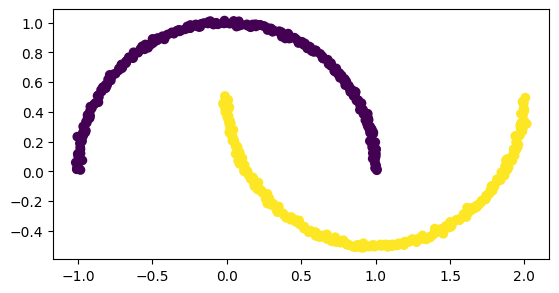

In [5]:
random_state = 17
n_samples = 500
X, y = make_moons(n_samples=n_samples, noise=0.01, random_state=random_state)
#X, y = make_circles(n_samples=n_samples, noise=0.01, factor=0.3, random_state=random_state)
#X, y = make_blobs(n_samples=n_samples, centers=3, cluster_std=1.0, random_state=random_state)

fig, ax = plt.subplots()
_ = ax.scatter(X[:,0], X[:,1], c=y)
ax.set_aspect('equal')

In [6]:
def make_grid(n,X):
    """
        Generates a grid of points within the bounds of the given data.

        n : int
            The number of points along each dimension of the grid.
        X : numpy.ndarray
            A 2D array of shape (num_samples, 2) representing the input data.

        numpy.ndarray
            A 2D array of shape (n*n, 2) containing the grid points.
    """
    x_min, y_min = np.min(X, axis=0)
    x_max, y_max = np.max(X, axis=0)
    xy = np.mgrid[x_min:x_max:1j*n, y_min:y_max:1j*n].reshape(2,-1).T
    return xy

In [7]:
# Hyperparameters (to be tuned)
kernel = 'gaussian' # test 'linear' or 'gaussian'
sigma = 0.35
lbda = 10

# Define kernel
if kernel == 'linear':
    kernel = LinearKernel()
elif kernel == 'gaussian':
    kernel = GaussianKernel(sigma = sigma)
else:
    raise ValueError('Unknown kernel')


def KPCA_representation(X, kernel):
    """
    Compute the finite-dimensional representation of the principal components.

    Parameters
    ----------
    X : (n, d) numpy.ndarray
        The input data.

    Returns
    -------
    alpha : (n, k) numpy.ndarray
        The finite-dimensional representation of the principal components.
    """
    # get the kernel matrix, center it, get the eigenvectors and eigenvalues, change the variables.

    K = kernel.get_Kxx(X)
    Kc = center_train_gram_matrix(K)

    eignen_vals, eignen_vect = np.linalg.eig(Kc)

    idx = eignen_vals.argsort()[::-1]
    eignen_vals = eignen_vals[idx]
    eignen_vect = eignen_vect[:, idx]

    alpha = eignen_vect[:,:] / np.sqrt(eignen_vals[:])

    return alpha, eignen_vals

In [8]:
def principal_component(alpha, X, Z):
    """
    return the evaluation of the principal components at points Z.

    Parameters
    ----------
    alpha : (n, k) numpy.ndarray
        The finite-dimensional representation of the principal components
    X: (n, d) numpy.ndarray
        The input data.
    Z : (m, d) array
        points to where to evaluate the principal components.

    Returns
    -------
    (k, m) array
        value of the k principal components at points y.
    """
    Kxx, Kxz = kernel.get_Kxx(X) , kernel.get_Kxz(X,Z)
    Kc = center_test_gram_matrix(Kxx, Kxz)

    components = alpha.T @ Kc

    return components


In [9]:
# Fonction pour générer une grille
def make_grid(n, X):
    """
    Generates a grid of points within the bounds of the given data.
    """
    x_min, y_min = np.min(X, axis=0) - 0.5
    x_max, y_max = np.max(X, axis=0) + 0.5
    xy = np.mgrid[x_min:x_max:1j*n, y_min:y_max:1j*n].reshape(2,-1).T
    return xy

# Fonction pour visualiser les résultats avec une meilleure disposition des graphes
def plot_kpca_results(X, y, sigmas, n_eval=100, max_cols=5):
    """
    Plot KPCA results for different sigma values with enhanced decision regions visualization.
    Organizes plots in a grid with a maximum number of columns for better readability.
    
    Parameters:
    ----------
    X : numpy.ndarray
        Input data of shape (n_samples, n_features)
    y : numpy.ndarray
        Labels of shape (n_samples,)
    sigmas : list or numpy.ndarray
        List of sigma values to try
    n_eval : int, default=100
        Number of points in each dimension of the evaluation grid
    max_cols : int, default=5
        Maximum number of plots per row
    
    Returns:
    -------
    fig : matplotlib.figure.Figure
        The figure containing the plots
    """
    n_sigmas = len(sigmas)
    
    # Calculer le nombre de lignes et colonnes nécessaires
    n_cols = min(n_sigmas, max_cols)
    n_rows = (n_sigmas + n_cols - 1) // n_cols  # Arrondi supérieur pour le nombre de lignes
    
    # Créer une figure avec 2 lignes pour chaque valeur de sigma (une ligne pour la projection d'origine, 
    # une ligne pour l'espace des composantes principales)
    fig, axes = plt.subplots(2 * n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    
    # S'assurer que axes est un tableau 2D même s'il n'y a qu'une seule ligne ou colonne
    if n_rows == 1 and n_cols == 1:
        axes = axes.reshape(2, 1)
    elif n_rows == 1:
        axes = axes.reshape(2, n_cols)
    elif n_cols == 1:
        axes = axes.reshape(2 * n_rows, 1)
    
    # Parcourir chaque valeur de sigma
    for i, sigma in enumerate(sigmas):
        # Calculer la position dans la grille
        row = (i // n_cols) * 2  # Multiplier par 2 car chaque sigma occupe 2 lignes
        col = i % n_cols
        
        # Définir les axes pour les deux visualisations
        ax1 = axes[row, col]
        ax2 = axes[row + 1, col]
        
        # Créer le noyau avec le sigma actuel
        kernel = GaussianKernel(sigma=sigma)
        
        # Calculer la représentation KPCA
        alpha, _ = KPCA_representation(X, kernel)
        
        # Calculer les valeurs propres pour l'affichage de la variance expliquée
        K = kernel.get_Kxx(X)
        Kc = center_train_gram_matrix(K)
        eigvals, _ = np.linalg.eig(Kc)
        eigvals = np.sort(eigvals)[::-1]  # Tri décroissant
        
        # Générer une grille pour la visualisation
        Z = make_grid(n_eval, X)
        
        # Calculer les composantes principales pour la grille et les données d'origine
        feval = principal_component(alpha, X, Z)
        fself = principal_component(alpha, X, X)
        
        # Afficher le pourcentage de variance expliquée
        explained_variance = eigvals / np.sum(eigvals) * 100
        
        # Visualisation 1: Les deux premières composantes projetées sur les données d'origine
        Ep = Z.reshape(n_eval*n_eval, 2).T.reshape(2, n_eval, n_eval)
        fxp = feval.reshape((feval.shape[0], n_eval, n_eval))
        
        # Utiliser contourf pour créer une carte de chaleur de la première composante principale
        if feval.shape[0] > 0:
            
            # Ajouter des contours pour la frontière de décision (où PC1 = 0)
            ax1.contour(Ep[0], Ep[1], fxp[0], colors='red', levels=[0], linewidths=2, 
                        linestyles='dashed', alpha=1.0)
            
            # Si on a une deuxième composante, la visualiser avec des contours
            if feval.shape[0] > 1:
                # Contours pour PC2 (noir)
                ax1.contour(Ep[0], Ep[1], fxp[1], colors='black', levels=10, 
                           linewidths=0.8, alpha=0.7)
                # Contour pour PC2 = 0 (autre frontière de décision)
                ax1.contour(Ep[0], Ep[1], fxp[1], colors='blue', levels=[0], 
                           linewidths=2, linestyles='dashed')
        
        # Afficher les données d'origine avec des marqueurs plus visibles
        scatter = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['red', 'blue']), 
                             edgecolors='k', s=50, alpha=0.9)
        
        
        # Ajouter une légende pour les frontières de décision
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color='red', lw=2, linestyle='dashed'),
            Line2D([0], [0], color='blue', lw=2, linestyle='dashed')
        ]
        ax1.legend(handles=legend_elements, loc='lower right')
        
        # Ajouter les titres et labels
        ax1.set_title(f'sigma={sigma:.2f}\nVariance: {explained_variance[0]:.1f}%' + 
                     (f', {explained_variance[1]:.1f}%' if len(explained_variance) > 1 else ''))
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_aspect('equal')
        ax1.grid(True, linestyle='--', alpha=0.3)
        
        # Visualisation 2: Projection des données dans l'espace des composantes principales
        # Vérifier qu'il y a suffisamment de composantes pour tracer
        if fself.shape[0] >= 2:
            # Tracer les axes à zéro pour montrer les quadrants
            ax2.axhline(y=0, color='blue', linestyle='--', alpha=0.8)
            ax2.axvline(x=0, color='red', linestyle='--', alpha=0.8)
            
            # Tracer les points projetés avec des marqueurs plus grands
            scatter2 = ax2.scatter(fself[0], fself[1], c=y, cmap=ListedColormap(['red', 'blue']), 
                                 edgecolors='k', s=50, alpha=0.9)
            
            ax2.set_title(f'Projection - sigma={sigma:.3f}')
            ax2.set_aspect('equal')
            ax2.grid(alpha=0.3)
        else:
            ax2.text(0.5, 0.5, "Pas assez de composantes", ha='center', va='center')
            ax2.set_title(f'Projection - sigma={sigma:.3f}')
            ax2.set_xticks([])
            ax2.set_yticks([])
    
    # Masquer les axes inutilisés si le nombre de sigmas n'est pas un multiple du nombre de colonnes
    for i in range(n_sigmas, n_rows * n_cols):
        row = (i // n_cols) * 2
        col = i % n_cols
        if row < 2 * n_rows and col < n_cols:
            axes[row, col].axis('off')
            axes[row + 1, col].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Impact du paramètre sigma sur la KPCA avec noyau gaussien", fontsize=16, y=1.02)
    
    return fig

/tmp/ipykernel_4569/2101909362.py:40: RuntimeWarning: invalid value encountered in sqrt
  alpha = eignen_vect[:,:] / np.sqrt(eignen_vals[:])
/telecom/TSiA 205/tp-env/lib/python3.12/site-packages/matplotlib/contour.py:1364: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/telecom/TSiA 205/tp-env/lib/python3.12/site-packages/matplotlib/contour.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/telecom/TSiA 205/tp-env/lib/python3.12/site-packages/numpy/ma/core.py:2892: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/telecom/TSiA 205/tp-env/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/telecom/TSiA 205/tp-env/lib/python3.12/site-packages/matplotlib/collections.py:200: Comp

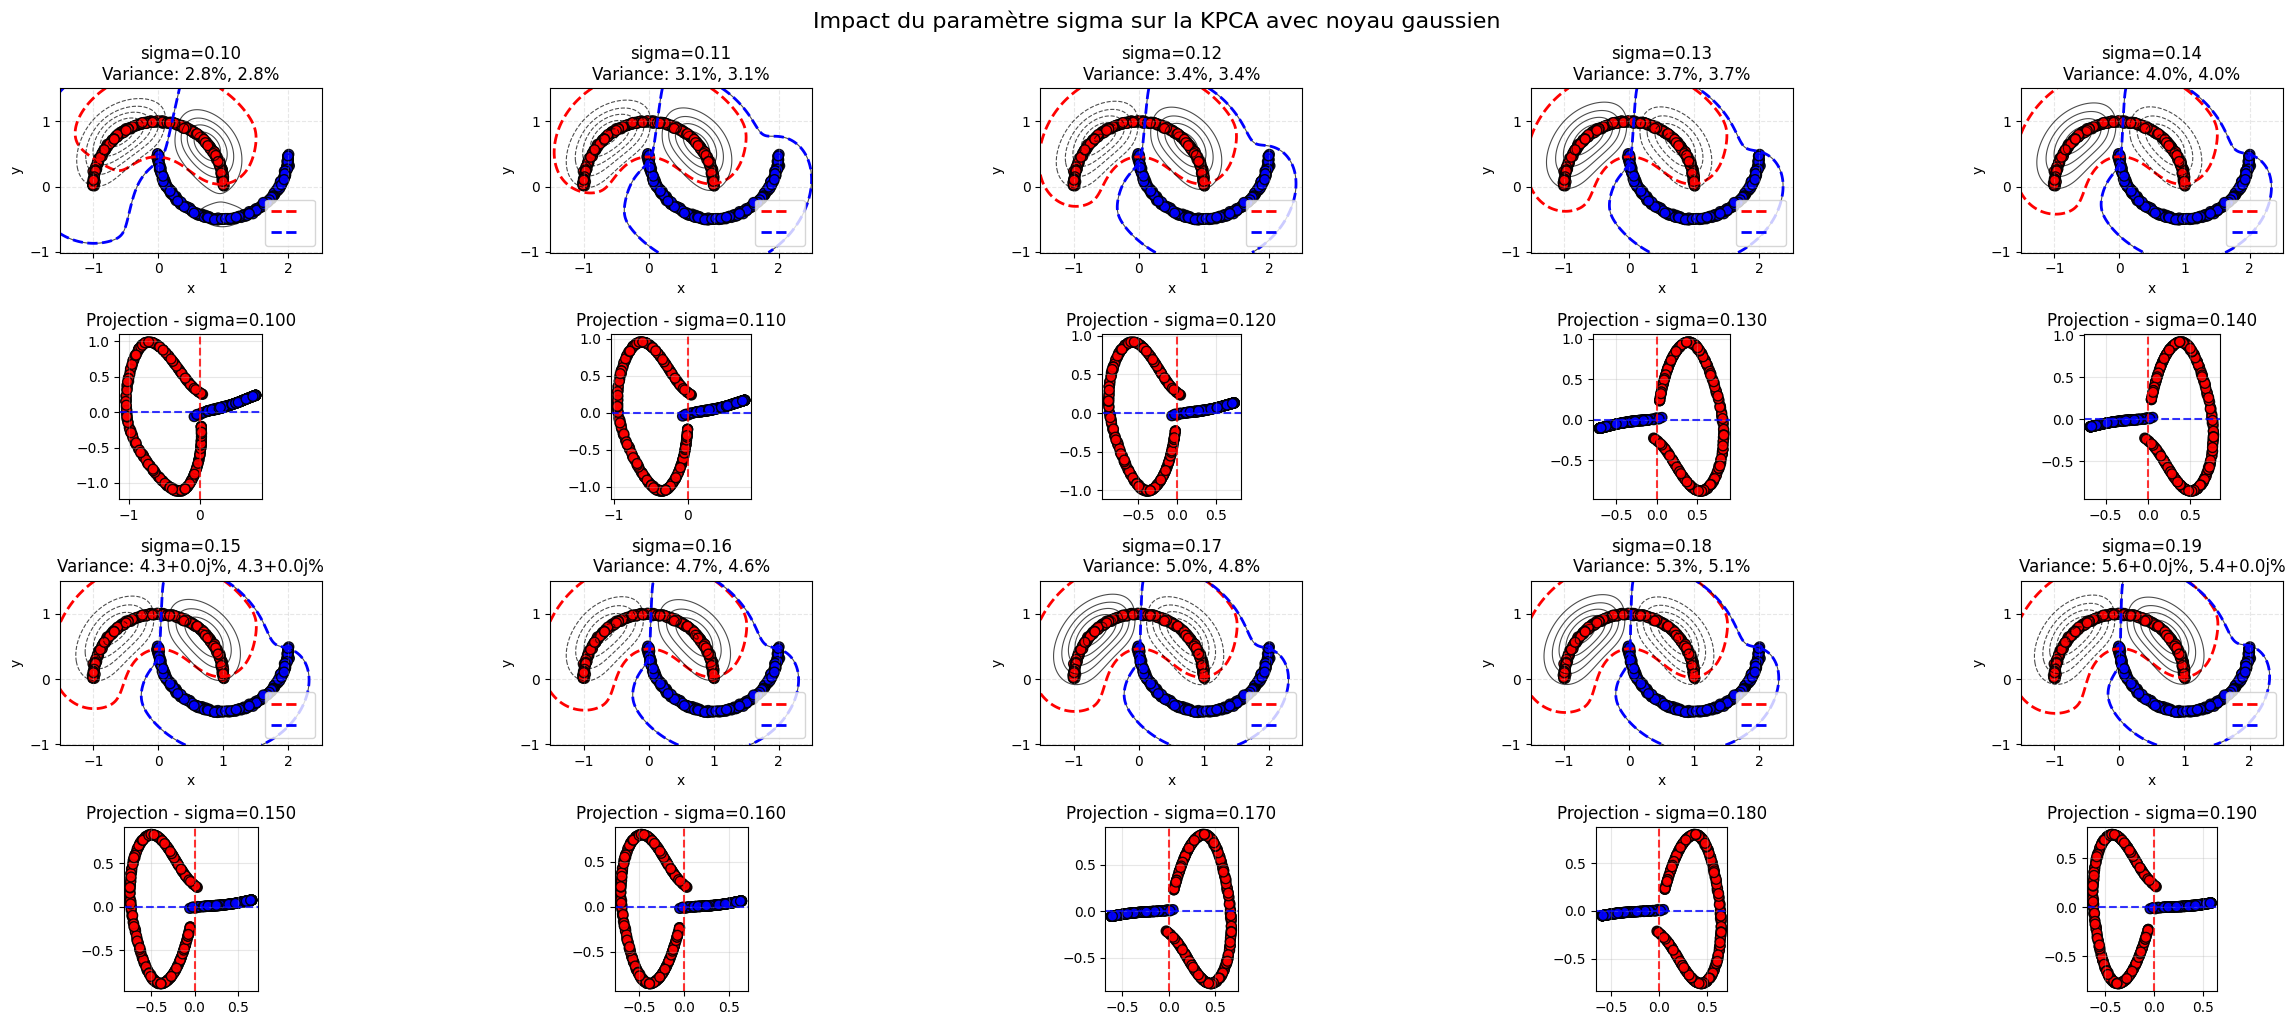

In [10]:
# Génération des données
random_state = 17
n_samples = 500
X, y = make_moons(n_samples=n_samples, noise=0.01, random_state=random_state)
# X, y = make_circles(n_samples=n_samples, noise=0.01, factor=0.3, random_state=random_state)
# X, y = make_blobs(n_samples=n_samples, centers=2, cluster_std=1.0, random_state=random_state)


# Valeurs de sigma à tester
sigmas = np.arange(0.10,0.20, 0.01)

# Visualiser les résultats avec un maximum de 5 graphes par ligne
fig = plot_kpca_results(X, y, sigmas, n_eval=300, max_cols=5)
plt.show()

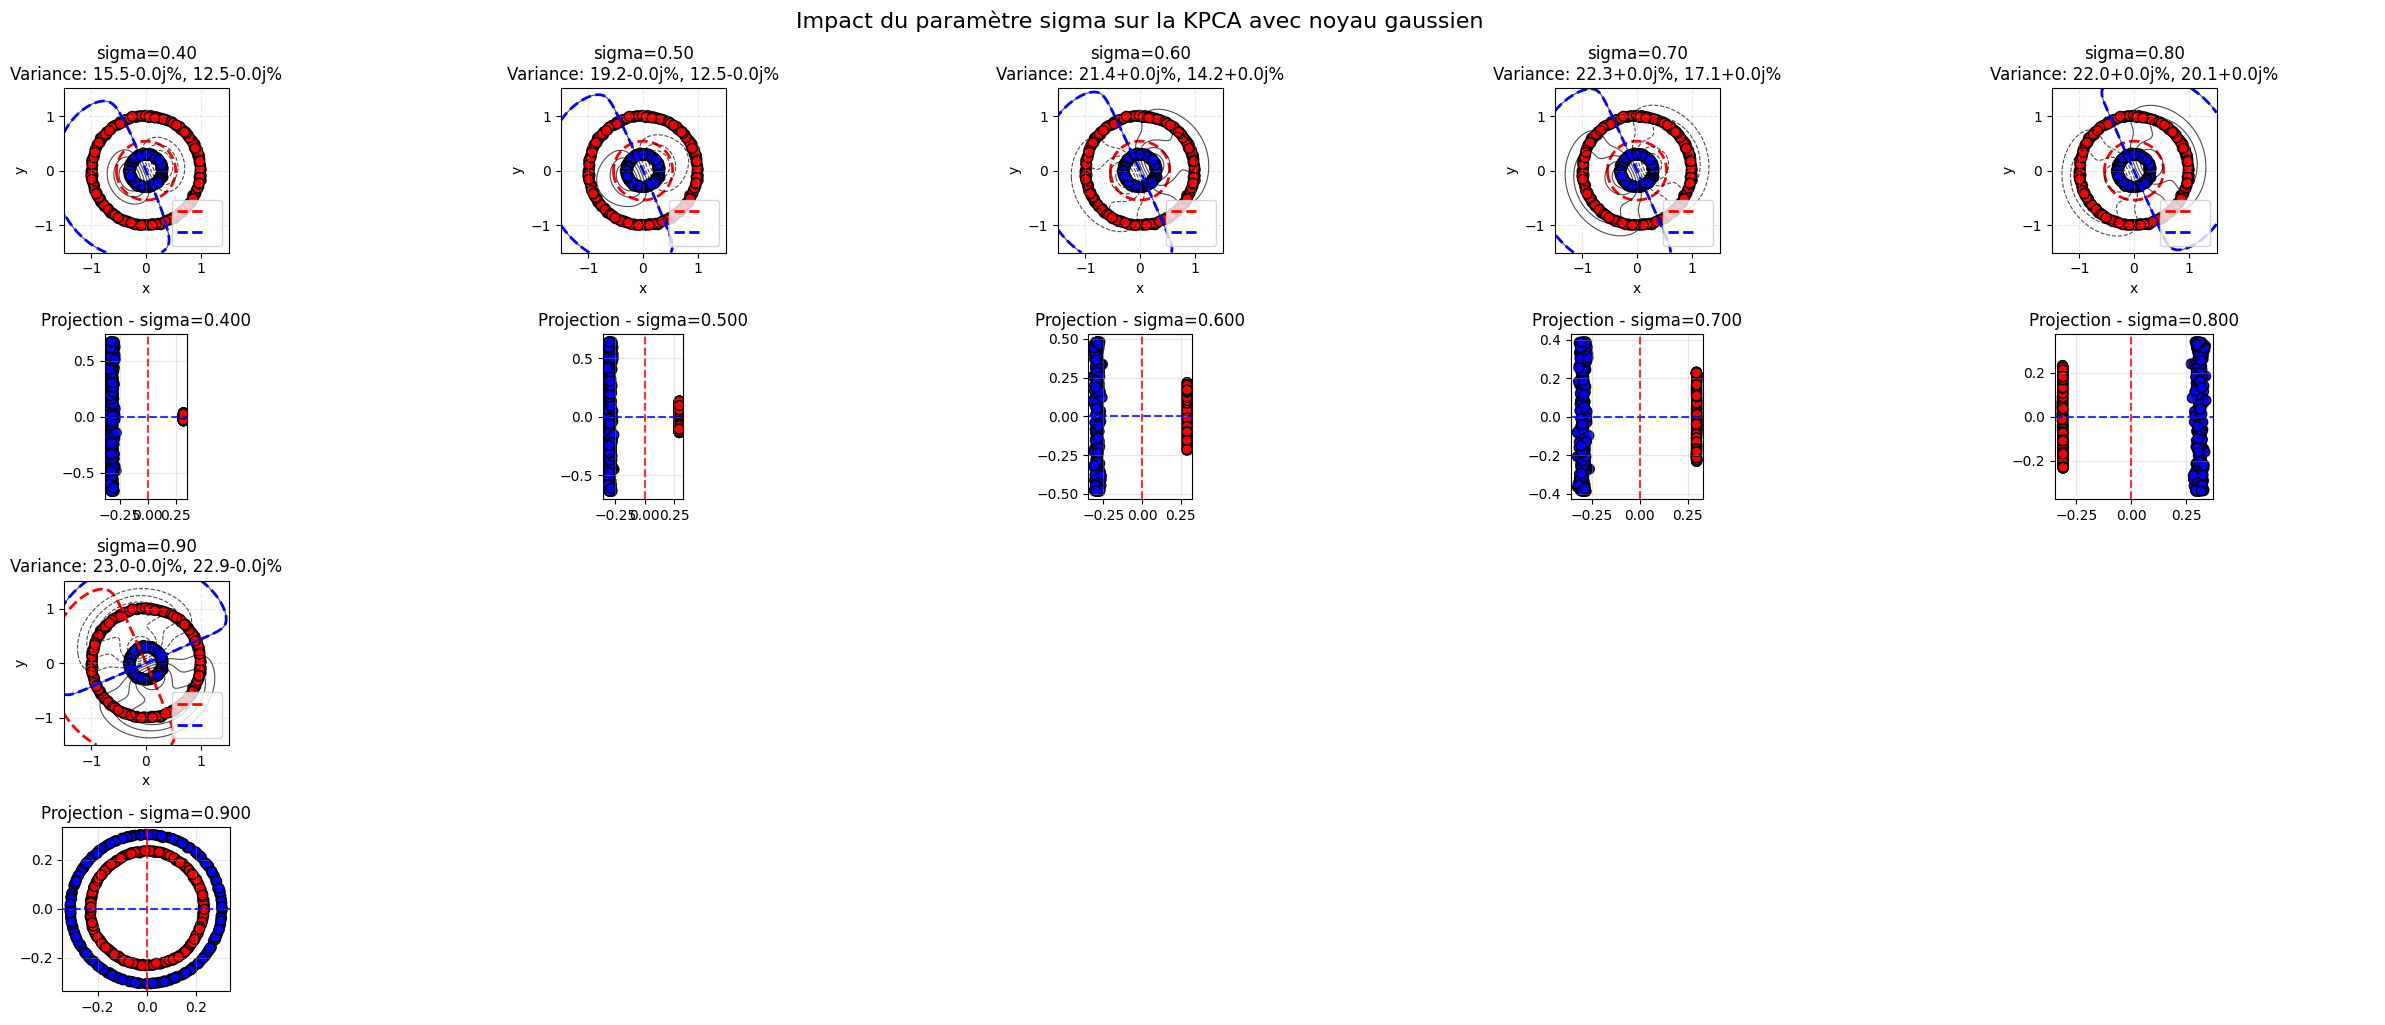

In [11]:
# Génération des données
random_state = 17
n_samples = 500
# X, y = make_moons(n_samples=n_samples, noise=0.01, random_state=random_state)
X, y = make_circles(n_samples=n_samples, noise=0.01, factor=0.3, random_state=random_state)
# X, y = make_blobs(n_samples=n_samples, centers=2, cluster_std=1.0, random_state=random_state)


# Valeurs de sigma à tester
sigmas = np.arange(0.4,1.0, 0.1)

# Visualiser les résultats avec un maximum de 5 graphes par ligne
fig = plot_kpca_results(X, y, sigmas, n_eval=300, max_cols=5)
plt.show()

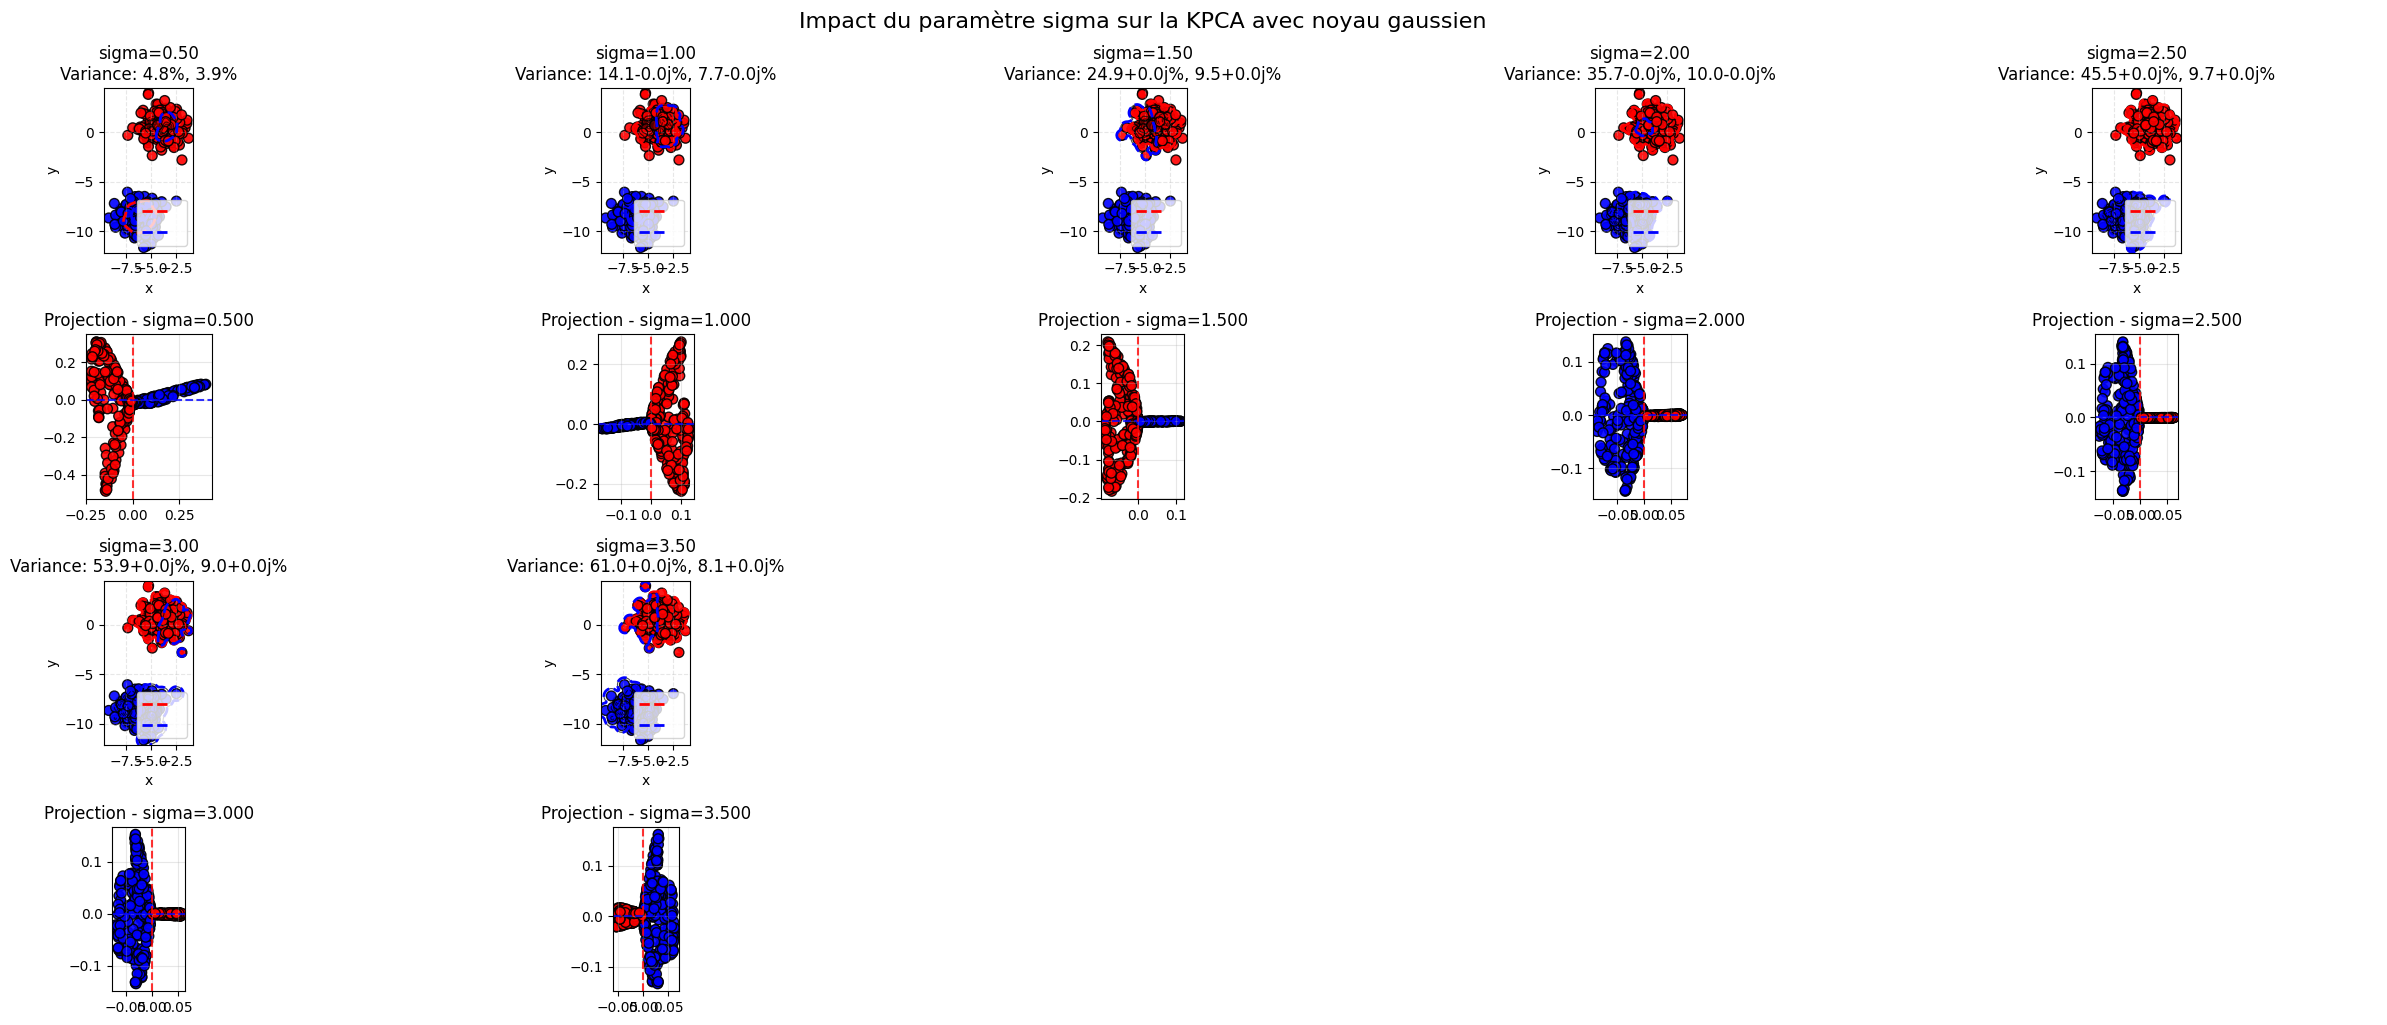

In [12]:
# Génération des données
random_state = 17
n_samples = 500
# X, y = make_moons(n_samples=n_samples, noise=0.01, random_state=random_state)
# X, y = make_circles(n_samples=n_samples, noise=0.01, factor=0.3, random_state=random_state)
X, y = make_blobs(n_samples=n_samples, centers=2, cluster_std=1.0, random_state=random_state)


# Valeurs de sigma à tester
sigmas = np.arange(0.5,4.0,0.5)

# Visualiser les résultats avec un maximum de 5 graphes par ligne
fig = plot_kpca_results(X, y, sigmas, n_eval=300, max_cols=5)
plt.show()


## Solving Regression under contamination

In real-world problems, it is not rare to observe outliers in collected data. For instance, this happens when a sensor has a default or faces some specific event such as an accident. In statistics, Huber (1964) proposed to describe this kind of situation with the framework of contamination. A data is polluted by a mixture of a (classic) Gaussian noise with a small variance and an arbitray distribution that represent contaminations. In this practical session, we propose to study regression under contamination, meaning that the output training data are contaminated as follows:

\begin{equation*}
y_i = f^*(x_i) + \delta_i \epsilon_i + ( 1 - \delta_i) u_i,
\end{equation*}
where $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$ is a Gaussian noise, $\delta_i \sim \mathcal{B}(p)$ is a Bernoulli variable, with $0 < p < 1$
and $u_i \sim Un([-b,+b])$, with $b > 0$, is a uniform variable.


We consider the general regression problem with a RKHS $\mathcal{H}_k$.
The **representer theorem** garantees that the solution of any problem of the form 

\begin{equation*}
\min_{f\in \mathcal{H}_k} \frac{1}{n}\sum_{i=1}^n \ell(f(x_i),y_i) + \lambda ||f||^2_{\mathcal{H}_k}
\end{equation*}

Can be written as

\begin{equation*}
\hat{f} = \sum_{i=1}^n \alpha_i \phi(x_i)
\end{equation*}

i.e.

\begin{equation*}
\hat{f}(x) = \sum_{i=1}^n \alpha_i k(x,x_i)
\end{equation*}

Meaning that finding the best function in $\mathcal{H}_k$ (which is infinite) is equivalent to find the right $\alpha \in \mathbb{R}^n$ !



Q6) Define a simple toy problem with $x$ and $y$ $\in \mathbb{R}$. For that, define a simple toy function $f^*$. Write the code to generate i.i.d. contaminated datasets $\{(x_i,y_i)\}_{i=1}^n$ for different values of $p$, $\sigma$ and $b$ for both training and test.

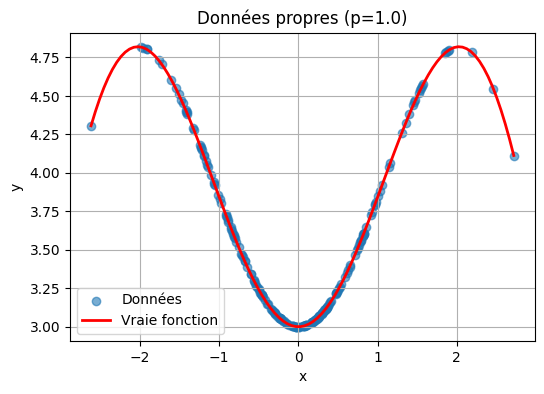

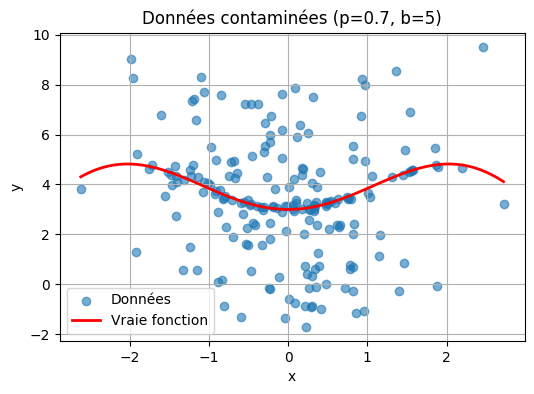

In [32]:
def gen_data(n, p, b, sigma=0.1, seed=42):
    np.random.seed(seed)
    x = np.random.randn(n)
    f = lambda x: np.sin(x)*x + 3
    delta = np.random.binomial(1, 1-p, n)
    y = f(x) + delta*sigma*np.random.randn(n) + (1-delta)*np.random.uniform(-b, b, n)
    return x, y, f

def plot_data(x, y, f=None, title=""):
    plt.figure(figsize=(6, 4))  # Taille réduite de (10, 6) à (6, 4)
    plt.scatter(x, y, alpha=0.6, label="Données")
    if f:
        x_grid = np.linspace(min(x), max(x), 100)
        plt.plot(x_grid, f(x_grid), 'r-', lw=2, label="Vraie fonction")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    
x_clean, y_clean, f = gen_data(200, p=1.0, b=0)
x_cont, y_cont, _ = gen_data(200, p=0.7, b=5)

plot_data(x_clean, y_clean, f, "Données propres (p=1.0)")
plot_data(x_cont, y_cont, f, "Données contaminées (p=0.7, b=5)")
plt.show()

Q7) Loss functions are not equal with respect to output contaminations. Consider the square loss $\ell_{square}(y,f(x)):= (y - f(x))^2$ and solve the so-called Kernel Ridge Regression problem. You can use the closed form solution (implement it) or the stochastic Gradient descent implementation of scikitlearn. 

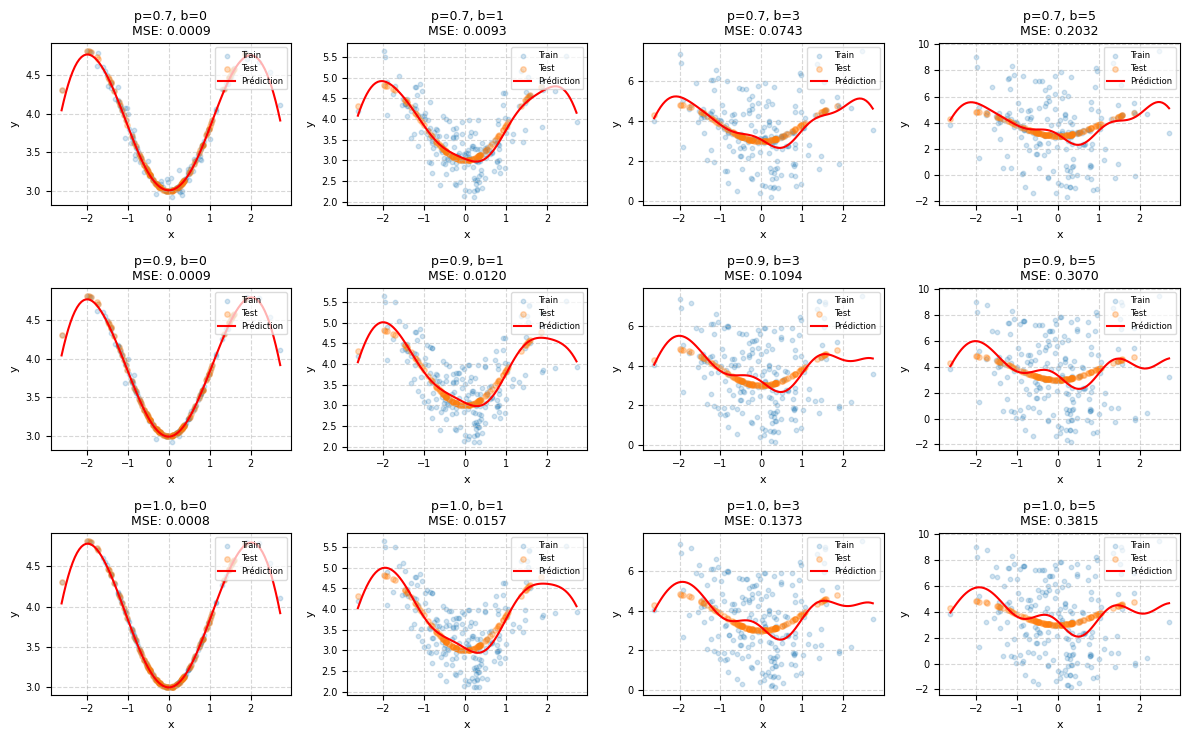

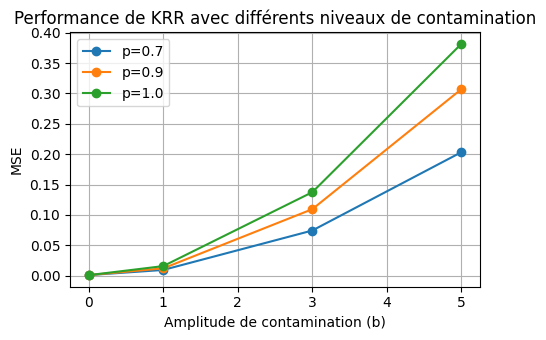

In [39]:
def rbf(x1, x2, gamma=1.0):
    return np.exp(-gamma * np.sum((x1[:, np.newaxis] - x2[np.newaxis, :]) ** 2, axis=2))

class KRR:
    def __init__(self, gamma=1.0, alpha=0.1):
        self.gamma = gamma
        self.alpha = alpha
        
    def fit(self, X, y):
        X = X.reshape(-1, 1) if X.ndim == 1 else X
        self.X_train = X
        K = rbf(X, X, self.gamma)
        self.alpha_coef = np.linalg.solve(K + self.alpha * np.eye(len(X)), y)
        return self
        
    def predict(self, X):
        X = X.reshape(-1, 1) if X.ndim == 1 else X
        K = rbf(X, self.X_train, self.gamma)
        return K @ self.alpha_coef

def visualize_krr(p_values, b_values):
    np.random.seed(42)
    x_test, y_test, f = gen_data(100, p=1.0, b=0, sigma=0.1)
    
    # Calculer le nombre de lignes et colonnes nécessaires
    n_plots = len(p_values) * len(b_values)
    cols = min(4, len(b_values))  # Maximum 4 colonnes
    rows = (n_plots + cols - 1) // cols
    
    # Créer la grille de subplots
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 2.5*rows))
    axes = axes.flatten() if rows > 1 or cols > 1 else [axes]
    
    results = {}
    plot_idx = 0
    
    for p in p_values:
        results[p] = []
        for b in b_values:
            x_train, y_train, _ = gen_data(200, p=p, b=b, sigma=0.1)
            krr = KRR(gamma=1.0, alpha=0.1)
            
            # Utiliser l'axe courant
            plt.sca(axes[plot_idx])
            mse = evaluate_model_subplot(x_train, y_train, x_test, y_test, krr, f"p={p}, b={b}", axes[plot_idx])
            results[p].append(mse)
            plot_idx += 1
    
    # Cacher les axes inutilisés
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    # Créer un graphique résumé séparé
    plt.figure(figsize=(5, 3.5))
    for p in p_values:
        plt.plot(b_values, results[p], 'o-', label=f"p={p}")
    plt.xlabel("Amplitude de contamination (b)")
    plt.ylabel("MSE")
    plt.title("Performance de KRR avec différents niveaux de contamination")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    return results

# Fonction helper pour tracer dans un subplot
def evaluate_model_subplot(x, y, x_test, y_test, model, title, ax):
    model.fit(x, y)
    y_pred = model.predict(x_test)
    mse = np.mean((y_test - y_pred) ** 2)
    
    # Tracer sur l'axe spécifié
    ax.scatter(x, y, alpha=0.2, s=10, label="Train")
    ax.scatter(x_test, y_test, alpha=0.3, s=15, label="Test")
    
    x_grid = np.linspace(min(min(x), min(x_test)), max(max(x), max(x_test)), 100).reshape(-1, 1)
    y_grid = model.predict(x_grid)
    ax.plot(x_grid, y_grid, 'r-', lw=1.5, label="Prédiction")
    
    ax.set_title(f"{title}\nMSE: {mse:.4f}", fontsize=9)
    ax.set_xlabel("x", fontsize=8)
    ax.set_ylabel("y", fontsize=8)
    ax.legend(fontsize=6, loc='upper right', framealpha=0.7)
    ax.tick_params(axis='both', labelsize=7)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    return mse

p_values = [0.7, 0.9, 1.0]
b_values = [0, 1, 3, 5]
results_krr = visualize_krr(p_values, b_values)

Q8) Evaluate the performance of KRR on a test set for different contaminated training sets.

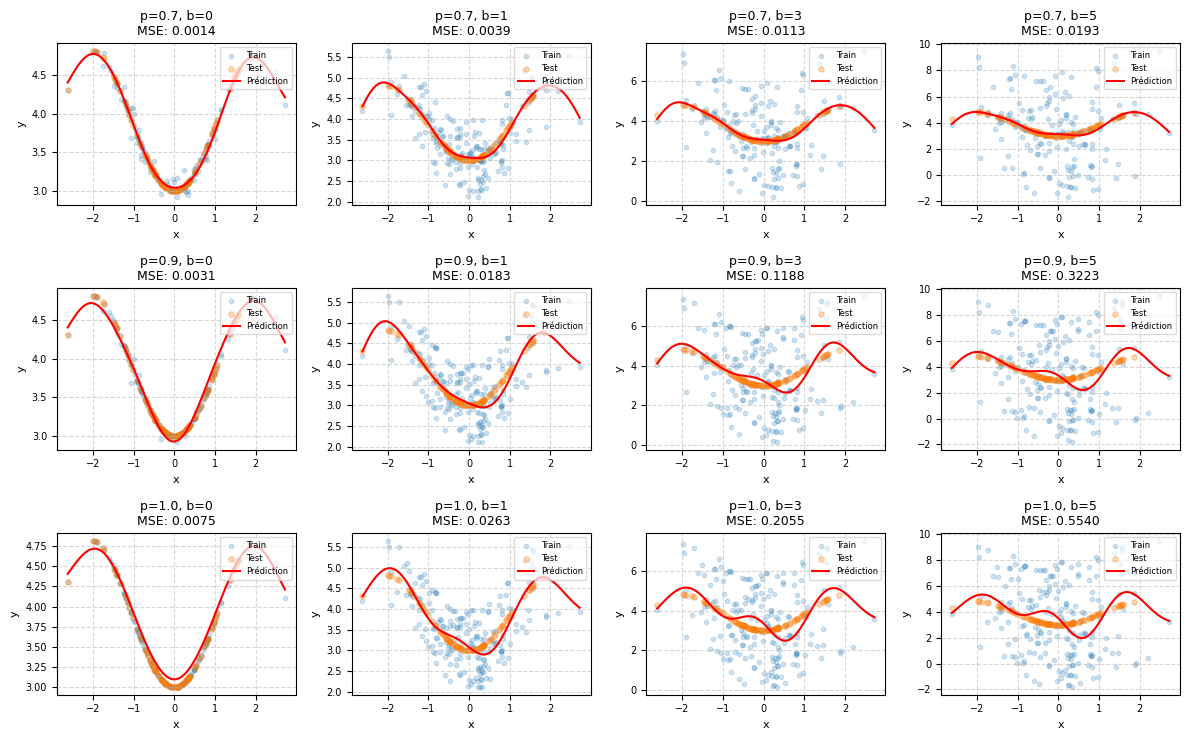

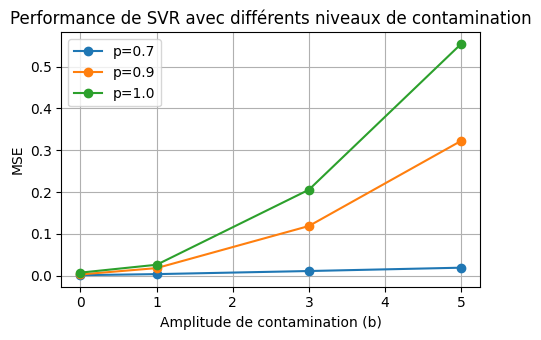

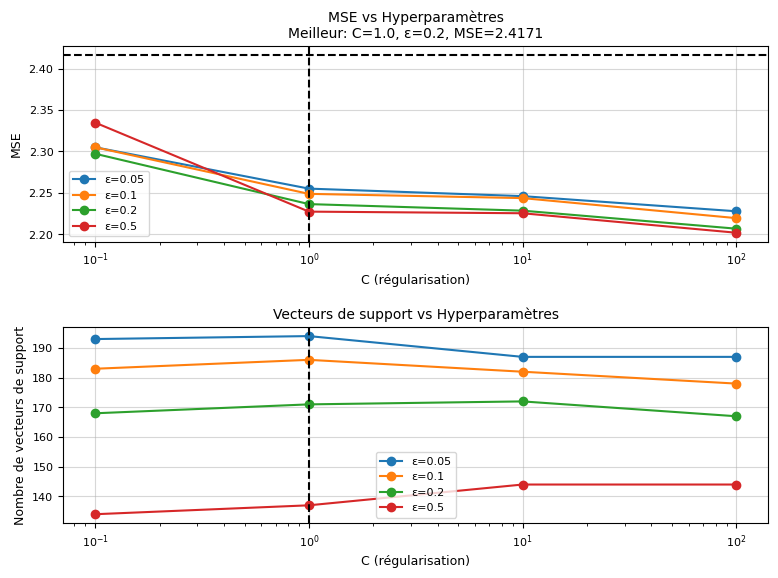

In [47]:
def visualize_svr(p_values, b_values):
    np.random.seed(42)
    x_test, y_test, f = gen_data(100, p=1.0, b=0, sigma=0.1)
    
    # Calculer le nombre de lignes et colonnes nécessaires
    n_plots = len(p_values) * len(b_values)
    cols = min(4, len(b_values))  # Maximum 4 colonnes
    rows = (n_plots + cols - 1) // cols
    
    # Créer la grille de subplots
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 2.5*rows))
    axes = axes.flatten() if rows > 1 or cols > 1 else [axes]
    
    results = {}
    plot_idx = 0
    
    for p in p_values:
        results[p] = []
        for b in b_values:
            x_train, y_train, _ = gen_data(200, p=p, b=b, sigma=0.1)
            
            svr = SVR(kernel='rbf', gamma=1.0, C=10.0, epsilon=0.1)
            
            # Utiliser l'axe courant
            plt.sca(axes[plot_idx])
            mse = evaluate_model_subplot(x_train, y_train, x_test, y_test, svr, f"p={p}, b={b}", axes[plot_idx])
            results[p].append(mse)
            plot_idx += 1
    
    # Cacher les axes inutilisés
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    # Créer un graphique résumé séparé
    plt.figure(figsize=(5, 3.5))
    for p in p_values:
        plt.plot(b_values, results[p], 'o-', label=f"p={p}")
    plt.xlabel("Amplitude de contamination (b)")
    plt.ylabel("MSE")
    plt.title("Performance de SVR avec différents niveaux de contamination")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    return results

# Cette fonction est la même utilisée pour KRR, elle s'occupe de tracer dans chaque subplot
def evaluate_model_subplot(x, y, x_test, y_test, model, title, ax):
    if isinstance(model, SVR):
        model.fit(x.reshape(-1, 1), y)
        y_pred = model.predict(x_test.reshape(-1, 1))
    else:
        model.fit(x, y)
        y_pred = model.predict(x_test)
        
    mse = np.mean((y_test - y_pred) ** 2)
    
    # Tracer sur l'axe spécifié avec des points plus petits pour moins encombrer
    ax.scatter(x, y, alpha=0.2, s=10, label="Train")
    ax.scatter(x_test, y_test, alpha=0.3, s=15, label="Test")
    
    x_grid = np.linspace(min(min(x), min(x_test)), max(max(x), max(x_test)), 100).reshape(-1, 1)
    
    if isinstance(model, SVR):
        y_grid = model.predict(x_grid)
    else:
        y_grid = model.predict(x_grid)
        
    ax.plot(x_grid, y_grid, 'r-', lw=1.5, label="Prédiction")
    
    ax.set_title(f"{title}\nMSE: {mse:.4f}", fontsize=9)
    ax.set_xlabel("x", fontsize=8)
    ax.set_ylabel("y", fontsize=8)
    ax.legend(fontsize=6, loc='upper right', framealpha=0.7)
    ax.tick_params(axis='both', labelsize=7)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    return mse

def study_svr_hyperparams(x, y, epsilons, C_values):
    results = {}
    x = x.reshape(-1, 1)
    
    param_grid = {'epsilon': epsilons, 'C': C_values}
    grid = GridSearchCV(SVR(kernel='rbf', gamma=1.0), 
                       param_grid, cv=5, 
                       scoring='neg_mean_squared_error')
    grid.fit(x, y)
    
    best_params = grid.best_params_
    best_score = -grid.best_score_
    
    for eps in epsilons:
        results[eps] = []
        for C in C_values:
            svr = SVR(kernel='rbf', gamma=1.0, epsilon=eps, C=C)
            svr.fit(x, y)
            y_pred = svr.predict(x)
            mse = mean_squared_error(y, y_pred)
            n_sv = len(svr.support_)
            results[eps].append((mse, n_sv))
    
    # Figure plus compacte
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))
    
    # Premier subplot pour MSE
    ax1 = axes[0]
    for eps in epsilons:
        ax1.plot(C_values, [r[0] for r in results[eps]], 'o-', label=f"ε={eps}")
    ax1.axvline(x=best_params['C'], color='k', linestyle='--')
    ax1.axhline(y=best_score, color='k', linestyle='--')
    ax1.set_xlabel("C (régularisation)", fontsize=9)
    ax1.set_ylabel("MSE", fontsize=9)
    ax1.set_title(f"MSE vs Hyperparamètres\nMeilleur: C={best_params['C']}, ε={best_params['epsilon']}, MSE={best_score:.4f}", fontsize=10)
    ax1.set_xscale('log')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.5)
    ax1.tick_params(axis='both', labelsize=8)
    
    # Deuxième subplot pour le nombre de vecteurs de support
    ax2 = axes[1]
    for eps in epsilons:
        ax2.plot(C_values, [r[1] for r in results[eps]], 'o-', label=f"ε={eps}")
    ax2.axvline(x=best_params['C'], color='k', linestyle='--')
    ax2.set_xlabel("C (régularisation)", fontsize=9)
    ax2.set_ylabel("Nombre de vecteurs de support", fontsize=9)
    ax2.set_title("Vecteurs de support vs Hyperparamètres", fontsize=10)
    ax2.set_xscale('log')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.5)
    ax2.tick_params(axis='both', labelsize=8)
    
    plt.tight_layout(pad=1.5)
    return best_params, best_score

p_values = [0.7, 0.9, 1.0]
b_values = [0, 1, 3, 5]
results_svr = visualize_svr(p_values, b_values)

x_train, y_train, _ = gen_data(200, p=0.8, b=3, sigma=0.1)
epsilons = [0.05, 0.1, 0.2, 0.5]
C_values = [0.1, 1.0, 10.0, 100.0]
best_params, _ = study_svr_hyperparams(x_train, y_train, epsilons, C_values)

Q10) Let us consider the so-called $\epsilon$-insensitive loss:
   $$\ell_{\epsilon}(y,f(x)):= \max(0, |y - f(x)| -\epsilon)$$
Solve the Support Vector regression problem using this loss and squared norm penalty. There exist two ways to solve this problem: either i) you notice that the problem wriets as a convex programme with affine inequality constraint and dualize the problem (at some point we ned to use functional derivative of $f$ when deploying KKT), or ii) apply representer theorem and write the primal problem with $\alpha \in \mathbb{R}^n$. Introduce slack variables for the two types of errors (positive and negative): $\xi^+ \in \mathbb{R}^n$ and $\xi^- \in \mathbb{R}^n$. Then apply Lagrangian relaxation (KKT conditions) and write the problem  in the dual space. Choose one of the other way (split the classroom in two). Any way this leads to Support Vector Regression.
    

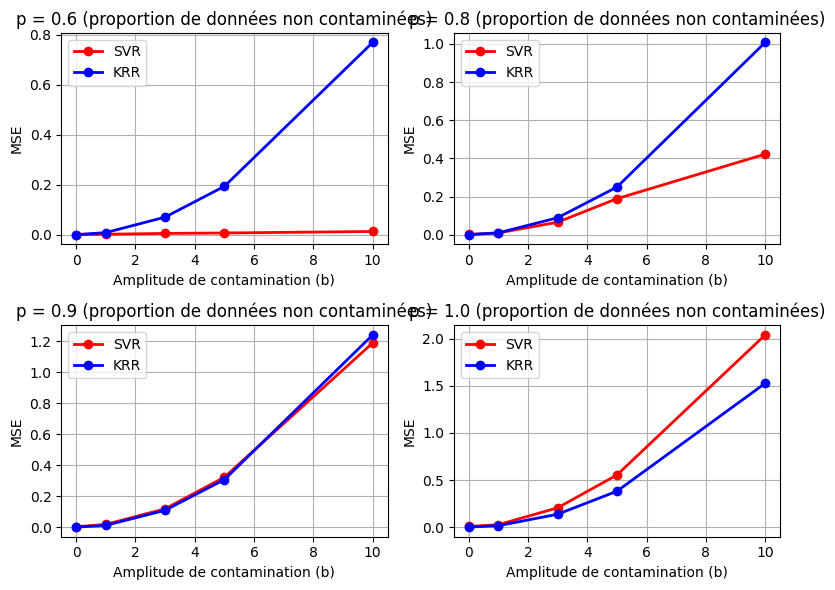

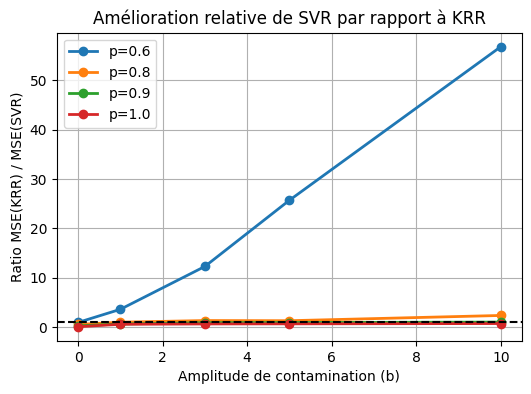

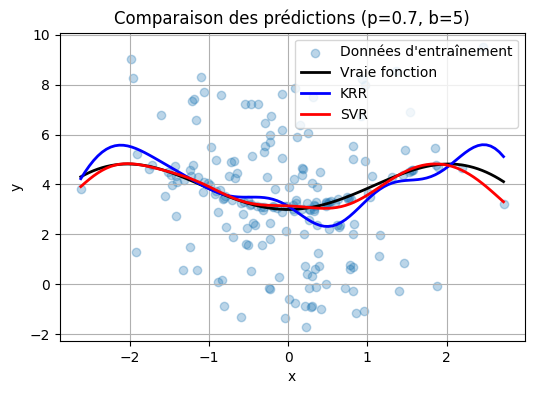

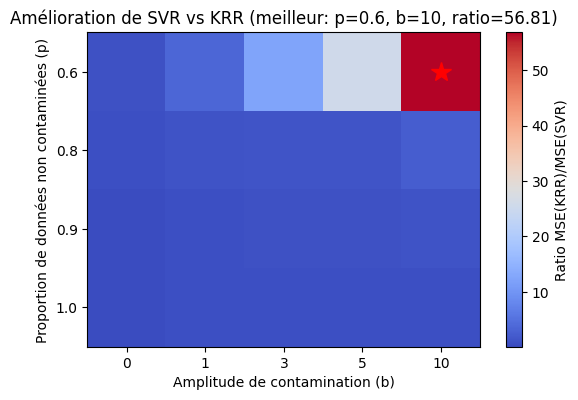

In [50]:
def compare_svr_krr(p_values, b_values):
    np.random.seed(42)
    x_test, y_test, f = gen_data(100, p=1.0, b=0, sigma=0.1)
    
    results = {'svr': {}, 'krr': {}}
    
    for p in p_values:
        results['svr'][p] = []
        results['krr'][p] = []
        
        for b in b_values:
            x_train, y_train, _ = gen_data(200, p=p, b=b, sigma=0.1)
            
            # KRR
            krr = KRR(gamma=1.0, alpha=0.1)
            krr.fit(x_train, y_train)
            krr_pred = krr.predict(x_test)
            krr_mse = mean_squared_error(y_test, krr_pred)
            results['krr'][p].append(krr_mse)
            
            # SVR
            svr = SVR(kernel='rbf', gamma=1.0, C=10.0, epsilon=0.1)
            svr.fit(x_train.reshape(-1, 1), y_train)
            svr_pred = svr.predict(x_test.reshape(-1, 1))
            svr_mse = mean_squared_error(y_test, svr_pred)
            results['svr'][p].append(svr_mse)
    
    return results

def plot_comparison(results, p_values, b_values):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    axes = axes.flatten()
    
    for i, p in enumerate(p_values):
        ax = axes[i]
        svr_mse = results['svr'][p]
        krr_mse = results['krr'][p]
        
        ax.plot(b_values, svr_mse, 'ro-', lw=2, label='SVR')
        ax.plot(b_values, krr_mse, 'bo-', lw=2, label='KRR')
        
        ax.set_xlabel('Amplitude de contamination (b)')
        ax.set_ylabel('MSE')
        ax.set_title(f'p = {p} (proportion de données non contaminées)')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    
    # Visualisation du ratio SVR/KRR
    plt.figure(figsize=(6, 4))
    for p in p_values:
        improvement = [krr/svr for krr, svr in zip(results['krr'][p], results['svr'][p])]
        plt.plot(b_values, improvement, 'o-', lw=2, label=f'p={p}')
    
    plt.axhline(y=1.0, color='k', linestyle='--')
    plt.xlabel('Amplitude de contamination (b)')
    plt.ylabel('Ratio MSE(KRR) / MSE(SVR)')
    plt.title('Amélioration relative de SVR par rapport à KRR')
    plt.legend()
    plt.grid(True)
    
    # Visualisation d'un exemple avec forte contamination
    x_train, y_train, f = gen_data(200, p=0.7, b=5, sigma=0.1)
    
    krr = KRR(gamma=1.0, alpha=0.1)
    krr.fit(x_train, y_train)
    
    svr = SVR(kernel='rbf', gamma=1.0, C=10.0, epsilon=0.1)
    svr.fit(x_train.reshape(-1, 1), y_train)
    
    x_grid = np.linspace(min(x_train), max(x_train), 100)
    
    plt.figure(figsize=(6, 4))
    plt.scatter(x_train, y_train, alpha=0.3, label='Données d\'entraînement')
    plt.plot(x_grid, f(x_grid), 'k-', lw=2, label='Vraie fonction')
    plt.plot(x_grid, krr.predict(x_grid), 'b-', lw=2, label='KRR')
    plt.plot(x_grid, svr.predict(x_grid.reshape(-1, 1)), 'r-', lw=2, label='SVR')
    plt.title('Comparaison des prédictions (p=0.7, b=5)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)

p_values = [0.6, 0.8, 0.9, 1.0]
b_values = [0, 1, 3, 5, 10]
comparison_results = compare_svr_krr(p_values, b_values)
plot_comparison(comparison_results, p_values, b_values)

# Analyse visuelle des résultats
def visualize_results_analysis(results, p_values, b_values):
    # Calculer l'amélioration moyenne pour chaque combinaison p/b
    improvements = {}
    best_case = {'ratio': 0, 'p': 0, 'b': 0}
    
    for p in p_values:
        improvements[p] = {}
        for i, b in enumerate(b_values):
            ratio = results['krr'][p][i] / results['svr'][p][i]
            improvements[p][b] = ratio
            
            if ratio > best_case['ratio']:
                best_case = {'ratio': ratio, 'p': p, 'b': b}
    
    # Créer une heatmap des améliorations
    plt.figure(figsize=(6, 4))
    heatmap_data = np.zeros((len(p_values), len(b_values)))
    
    for i, p in enumerate(p_values):
        for j, b in enumerate(b_values):
            heatmap_data[i, j] = improvements[p][b]
    
    plt.imshow(heatmap_data, cmap='coolwarm')
    plt.colorbar(label='Ratio MSE(KRR)/MSE(SVR)')
    
    plt.xticks(range(len(b_values)), b_values)
    plt.yticks(range(len(p_values)), p_values)
    plt.xlabel('Amplitude de contamination (b)')
    plt.ylabel('Proportion de données non contaminées (p)')
    
    # Marquer le meilleur cas
    best_i = p_values.index(best_case['p'])
    best_j = b_values.index(best_case['b'])
    plt.plot(best_j, best_i, 'r*', markersize=15)
    
    plt.title(f'Amélioration de SVR vs KRR (meilleur: p={best_case["p"]}, b={best_case["b"]}, ratio={best_case["ratio"]:.2f})')
    plt.tight_layout()

visualize_results_analysis(comparison_results, p_values, b_values)

Q11) First study the behaviour of SVR depending on the choice of the hyperparameters $\epsilon$ and $\lambda$ on the toy problem without contaminations ($\delta_i=1$ is a dterminstic and constant.) 

In [22]:
class SupportVectorRegression:
    def __init__(self, C=1.0, epsilon=0.1, gamma=1.0):
        self.C = C
        self.epsilon = epsilon
        self.gamma = gamma
        self.support_vectors_ = None
        self.dual_coef_ = None
        self.intercept_ = 0
        
    def fit(self, X, y):
        X = X.reshape(-1, 1) if X.ndim == 1 else X
        n_samples = X.shape[0]
        K = rbf_kernel(X, X, gamma=self.gamma)
        P = cvxopt.matrix(np.vstack([
            np.hstack([K, -K]),
            np.hstack([-K, K])
        ]))
        q = cvxopt.matrix(np.hstack([
            self.epsilon * np.ones(n_samples) - y,
            self.epsilon * np.ones(n_samples) + y
        ]))
        G = cvxopt.matrix(np.vstack([
            np.eye(2 * n_samples),
            -np.eye(2 * n_samples)
        ]))
        h = cvxopt.matrix(np.hstack([
            self.C * np.ones(2 * n_samples),
            np.zeros(2 * n_samples)
        ]))
        A = cvxopt.matrix(np.hstack([
            np.ones(n_samples),
            -np.ones(n_samples)
        ]).reshape(1, 2 * n_samples))
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        coef = np.array(solution['x']).flatten()
        alpha = coef[:n_samples]
        alpha_star = coef[n_samples:]
        self.dual_coef_ = alpha - alpha_star
        sv_threshold = 1e-5
        sv_idx = np.where(np.abs(self.dual_coef_) > sv_threshold)[0]
        self.support_vectors_ = X[sv_idx]
        self.dual_coef_ = self.dual_coef_[sv_idx]
        margin_vectors = []
        for i in sv_idx:
            if alpha[i] > sv_threshold and alpha[i] < (self.C - sv_threshold):
                margin_vectors.append(i)
            elif alpha_star[i] > sv_threshold and alpha_star[i] < (self.C - sv_threshold):
                margin_vectors.append(i)
        if margin_vectors:
            b_tmp = 0
            for j in margin_vectors:
                b_tmp += y[j]
                b_tmp -= np.sum(self.dual_coef_ * K[sv_idx, j])
                b_tmp -= self.epsilon if alpha[j] > 0 else -self.epsilon
            self.intercept_ = b_tmp / len(margin_vectors)
        return self
    
    def predict(self, X):
        X = X.reshape(-1, 1) if X.ndim == 1 else X
        K = rbf_kernel(X, self.support_vectors_, gamma=self.gamma)
        return K @ self.dual_coef_ + self.intercept_
        
def study_svr_hyperparameters(X, y, epsilons, lambdas):
    results = {}
    for eps in epsilons:
        results[eps] = {}
        for lam in lambdas:
            C = 1.0 / lam
            svr = SupportVectorRegression(C=C, epsilon=eps, gamma=1.0)
            svr.fit(X, y)
            y_pred = svr.predict(X)
            mse = np.mean((y - y_pred) ** 2)
            num_sv = len(svr.support_vectors_)
            results[eps][lam] = {'mse': mse, 'num_sv': num_sv}
    return results

def visualize_hyperparameter_study(results, epsilons, lambdas):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    for eps in epsilons:
        plt.plot(lambdas, [results[eps][lam]['mse'] for lam in lambdas], 
                 marker='o', label=f'ε={eps}')
    plt.xlabel('λ (regularization)')
    plt.ylabel('MSE')
    plt.title('MSE vs Hyperparameters')
    plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.subplot(2, 1, 2)
    for eps in epsilons:
        plt.plot(lambdas, [results[eps][lam]['num_sv'] for lam in lambdas], 
                 marker='o', label=f'ε={eps}')
    plt.xlabel('λ (regularization)')
    plt.ylabel('Number of Support Vectors')
    plt.title('Support Vectors vs Hyperparameters')
    plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

Q12) Now, use the result of Q6) to evaluate performance of SVR as compared to KKR on contaminated distributions. 
What can you say about the behaviour of SVR.

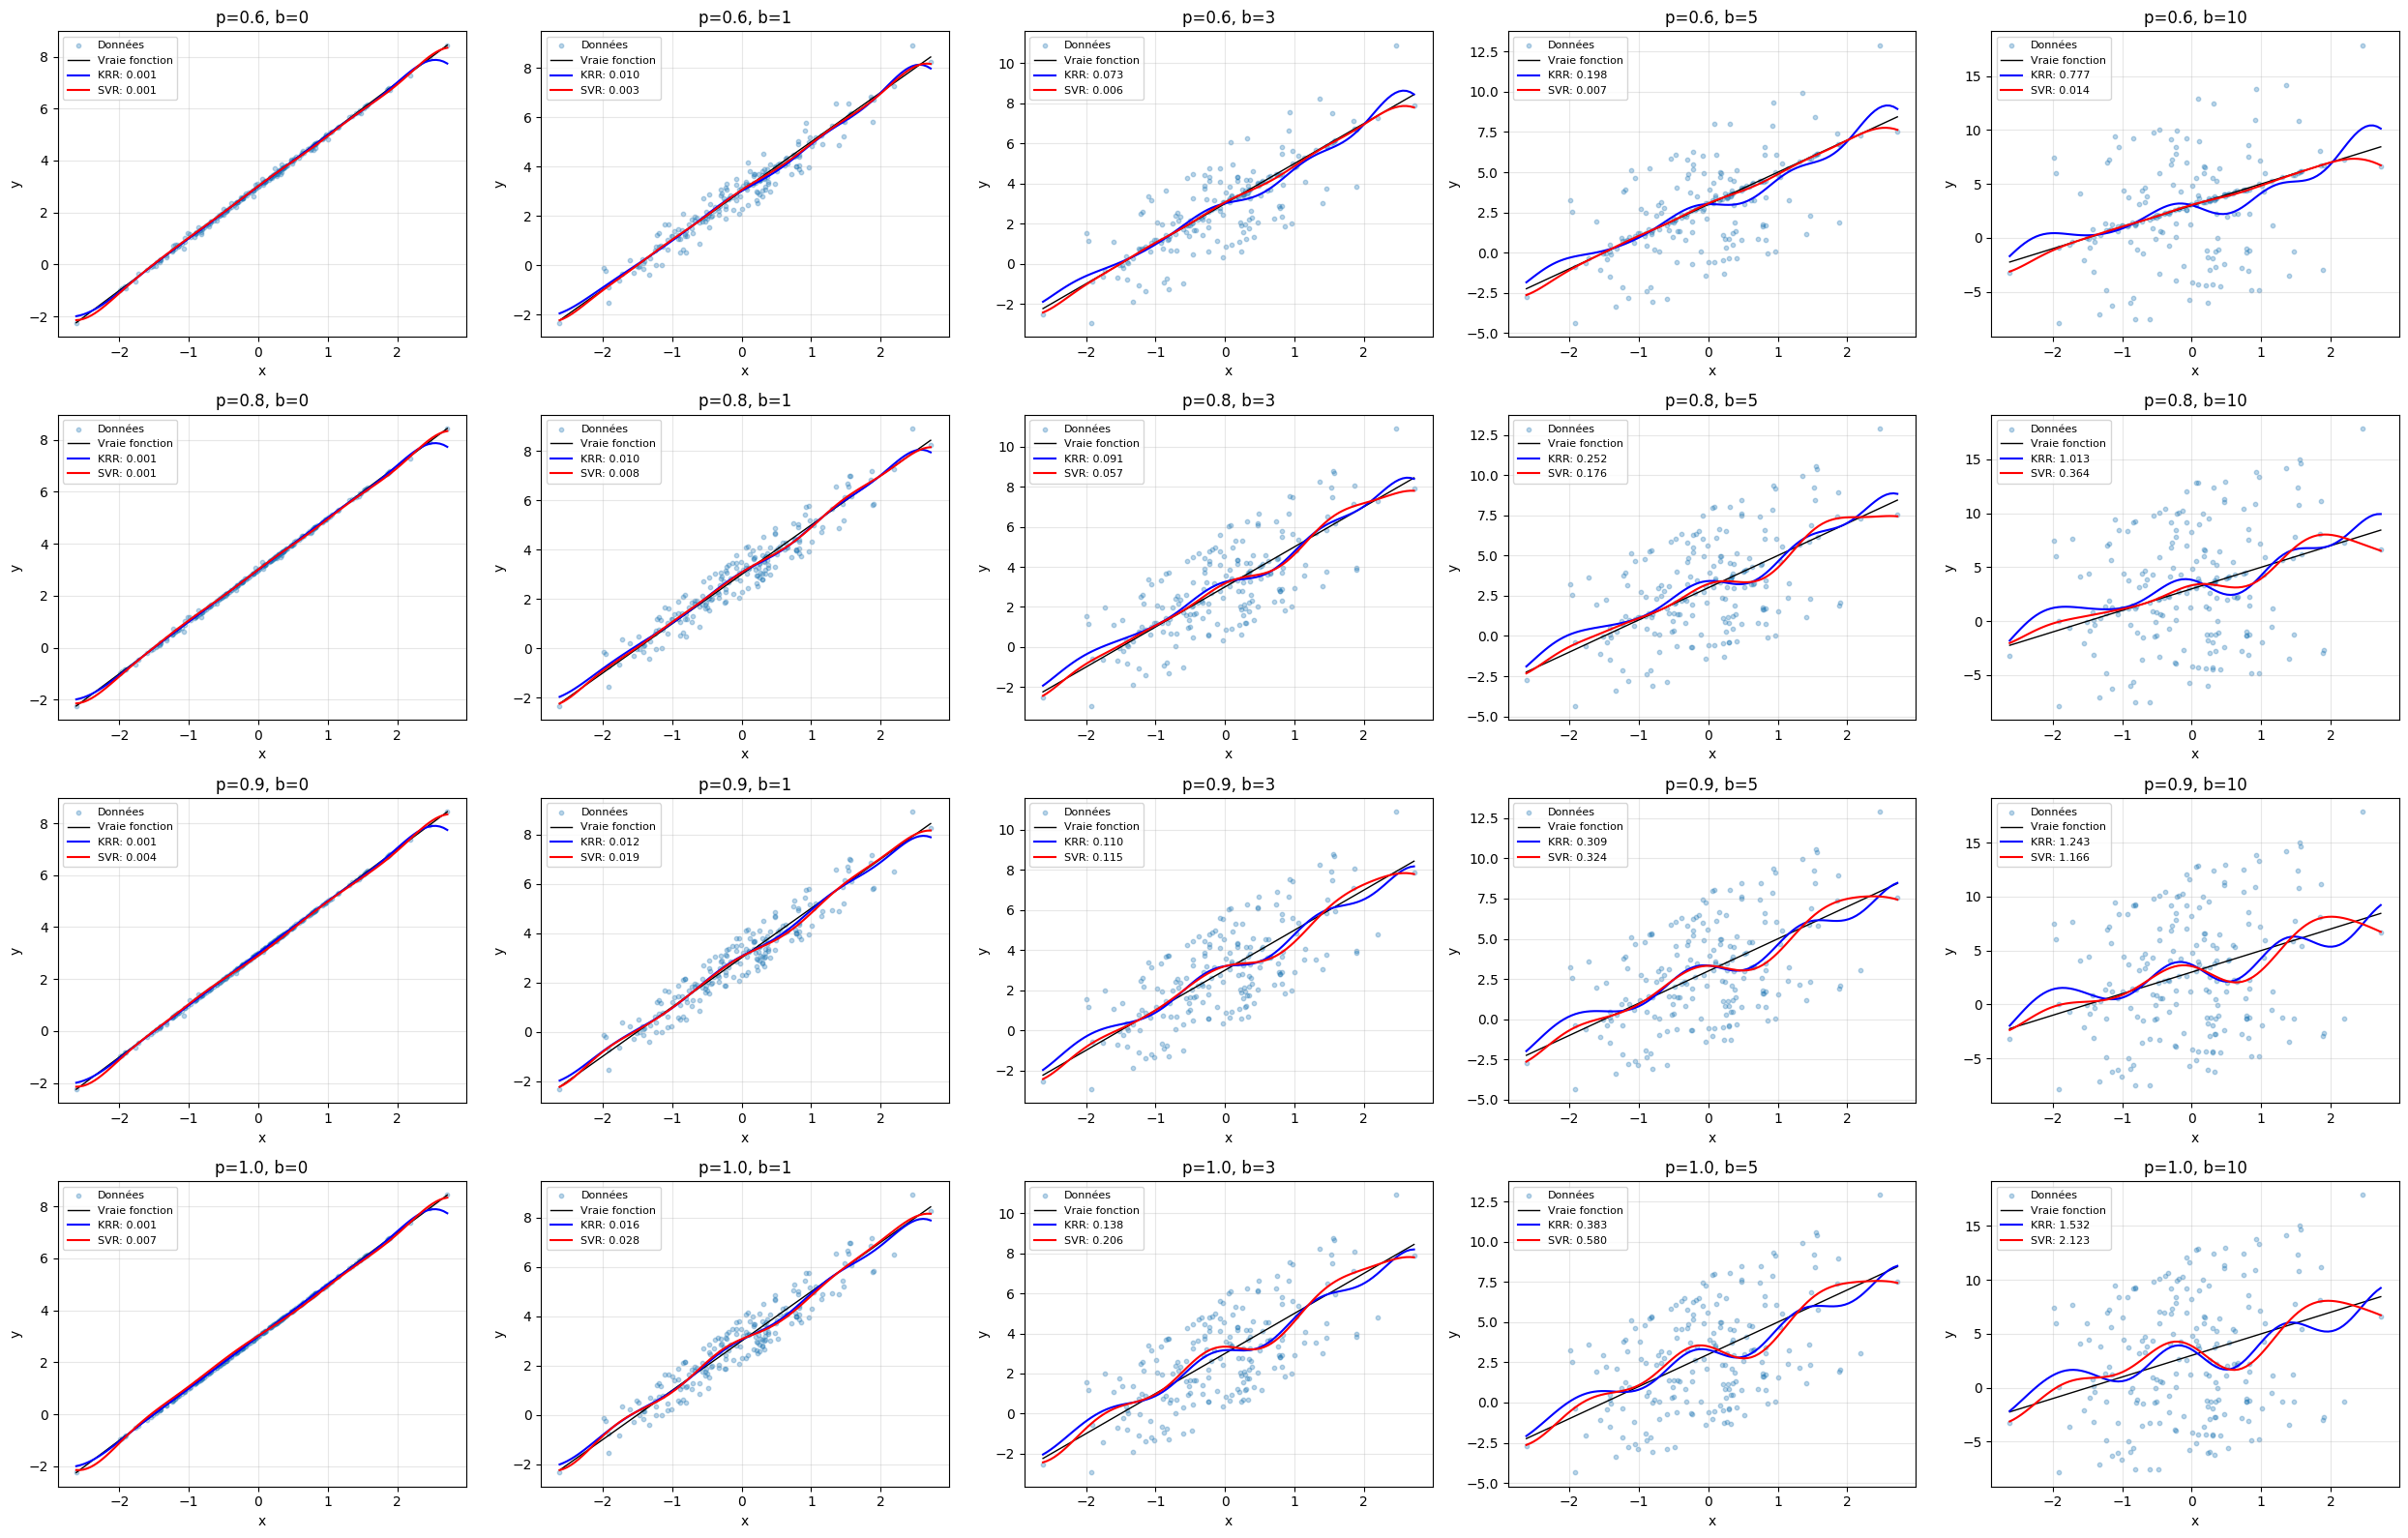

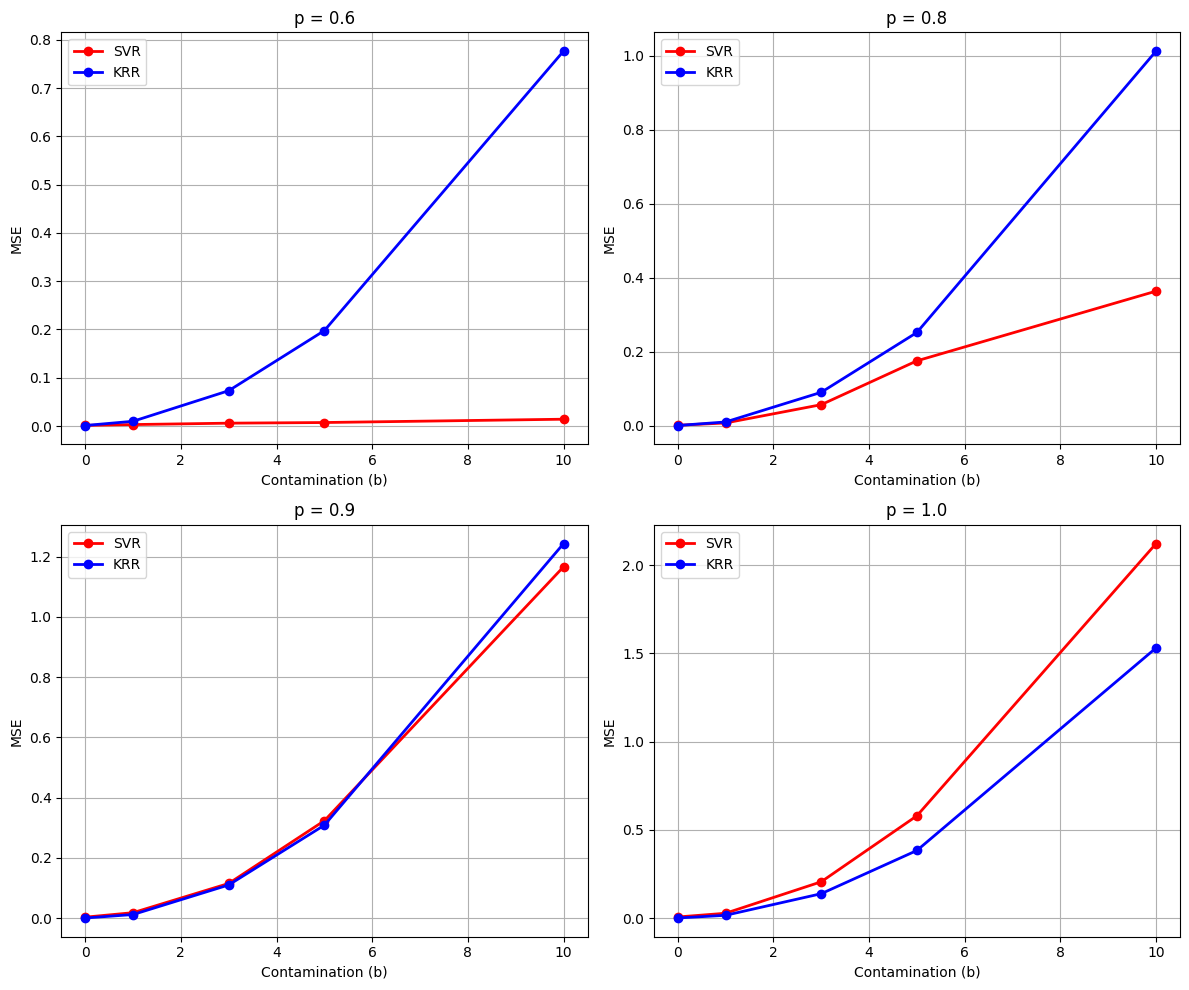

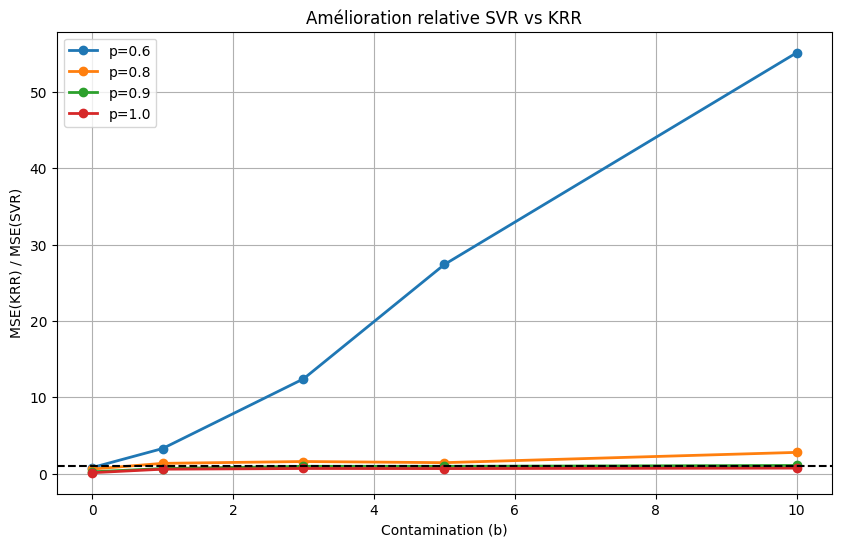

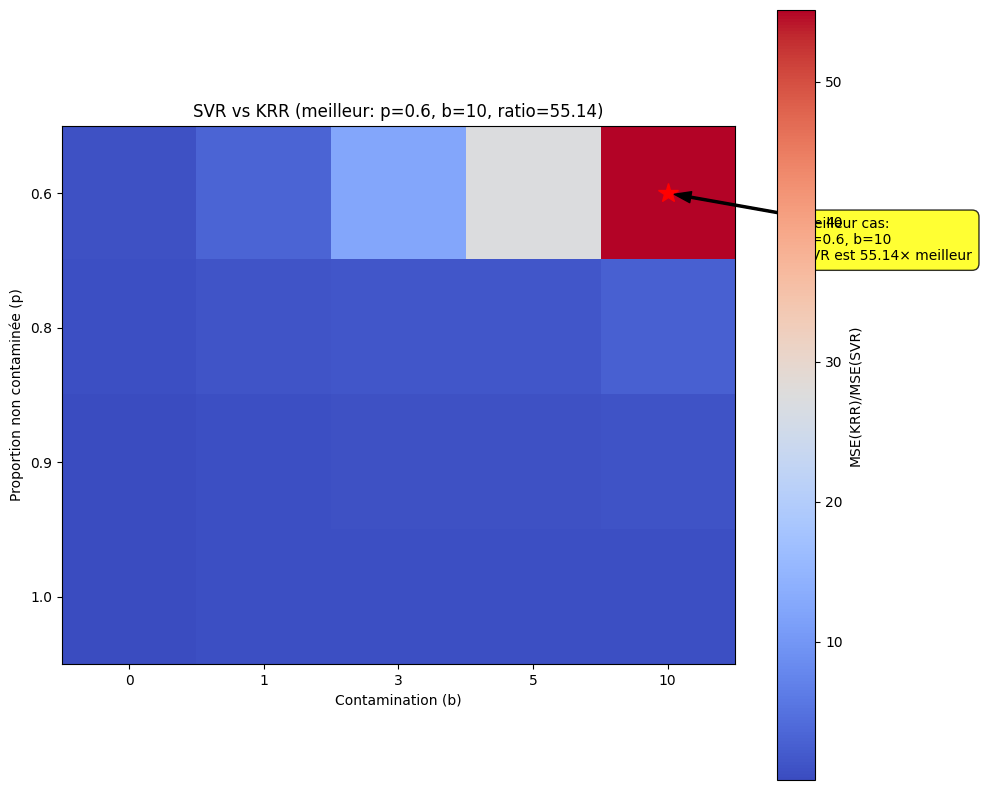

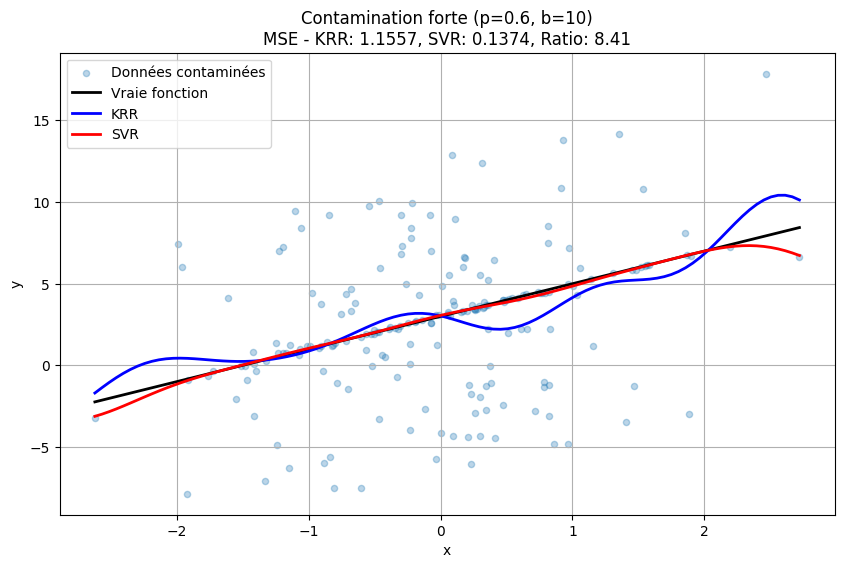

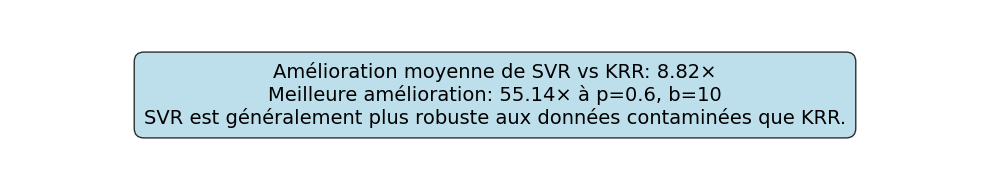

In [51]:
# --- Génération de données ---
def gen_data(n, p, b, sigma=0.1, seed=42):
    np.random.seed(seed)
    x = np.random.randn(n)
    f = lambda x: 2*x + 3
    delta = np.random.binomial(1, 1-p, n)
    y = f(x) + delta*sigma*np.random.randn(n) + (1-delta)*np.random.uniform(-b, b, n)
    return x, y, f

# --- KRR Simplifié ---
def rbf(x1, x2, gamma=1.0):
    x1 = x1.reshape(-1, 1) if x1.ndim == 1 else x1
    x2 = x2.reshape(-1, 1) if x2.ndim == 1 else x2
    return np.exp(-gamma * ((x1[:, np.newaxis] - x2) ** 2).sum(axis=2))

class KRR:
    def __init__(self, gamma=1.0, alpha=0.1):
        self.gamma, self.alpha = gamma, alpha
        
    def fit(self, X, y):
        self.X_train = X.reshape(-1, 1) if X.ndim == 1 else X
        K = rbf(X, X, self.gamma)
        self.alpha_coef = np.linalg.solve(K + self.alpha * np.eye(len(X)), y)
        return self
        
    def predict(self, X):
        X = X.reshape(-1, 1) if X.ndim == 1 else X
        K = rbf(X, self.X_train, self.gamma)
        return K @ self.alpha_coef

# --- Évaluation complète ---
def run_all_analyses():
    np.random.seed(0)
    # Générer des données
    x_test, y_test, f_true = gen_data(100, p=1.0, b=0)
    p_values = [0.6, 0.8, 0.9, 1.0]
    b_values = [0, 1, 3, 5, 10]
    
    # --- KRR vs SVR comparison ---
    results = {'svr': {}, 'krr': {}}
    
    # Créer une figure pour afficher les datasets et les fits
    n_rows = len(p_values)
    n_cols = len(b_values)
    fig_grid = plt.figure(figsize=(5*n_cols, 4*n_rows))
    
    for i, p in enumerate(p_values):
        results['svr'][p] = []
        results['krr'][p] = []
        
        for j, b in enumerate(b_values):
            # Générer des données d'entraînement contaminées
            x_train, y_train, _ = gen_data(200, p=p, b=b)
            
            # KRR
            krr = KRR(gamma=1.0, alpha=0.1)
            krr.fit(x_train, y_train)
            krr_pred = krr.predict(x_test)
            krr_mse = mean_squared_error(y_test, krr_pred)
            results['krr'][p].append(krr_mse)
            
            # SVR
            svr = SVR(kernel='rbf', gamma=1.0, C=10.0, epsilon=0.1)
            svr.fit(x_train.reshape(-1, 1), y_train)
            svr_pred = svr.predict(x_test.reshape(-1, 1))
            svr_mse = mean_squared_error(y_test, svr_pred)
            results['svr'][p].append(svr_mse)
            
            # Plot data and models
            ax = fig_grid.add_subplot(n_rows, n_cols, i*n_cols + j + 1)
            ax.scatter(x_train, y_train, alpha=0.3, s=10, label="Données")
            
            x_grid = np.linspace(min(x_train), max(x_train), 100)
            ax.plot(x_grid, f_true(x_grid), 'k-', lw=1, label="Vraie fonction")
            ax.plot(x_grid, krr.predict(x_grid), 'b-', lw=1.5, label=f"KRR: {krr_mse:.3f}")
            ax.plot(x_grid, svr.predict(x_grid.reshape(-1, 1)), 'r-', lw=1.5, label=f"SVR: {svr_mse:.3f}")
            
            ax.set_title(f"p={p}, b={b}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # --- Comparison Results ---
    fig_comp, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()
    
    for i, p in enumerate(p_values):
        ax = axs[i]
        svr_mse = results['svr'][p]
        krr_mse = results['krr'][p]
        
        ax.plot(b_values, svr_mse, 'ro-', lw=2, label='SVR')
        ax.plot(b_values, krr_mse, 'bo-', lw=2, label='KRR')
        
        ax.set_xlabel('Contamination (b)')
        ax.set_ylabel('MSE')
        ax.set_title(f'p = {p}')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    
    # --- Visualization of ratio SVR/KRR ---
    plt.figure(figsize=(10, 6))
    for p in p_values:
        improvement = [krr/svr for krr, svr in zip(results['krr'][p], results['svr'][p])]
        plt.plot(b_values, improvement, 'o-', lw=2, label=f'p={p}')
    
    plt.axhline(y=1.0, color='k', linestyle='--')
    plt.xlabel('Contamination (b)')
    plt.ylabel('MSE(KRR) / MSE(SVR)')
    plt.title('Amélioration relative SVR vs KRR')
    plt.legend()
    plt.grid(True)
    
    # --- Heatmap of improvement ---
    plt.figure(figsize=(10, 8))
    heatmap_data = np.zeros((len(p_values), len(b_values)))
    best_case = {'ratio': 0, 'p': 0, 'b': 0, 'i': 0, 'j': 0}
    
    for i, p in enumerate(p_values):
        for j, b in enumerate(b_values):
            ratio = results['krr'][p][j] / results['svr'][p][j]
            heatmap_data[i, j] = ratio
            
            if ratio > best_case['ratio']:
                best_case = {'ratio': ratio, 'p': p, 'b': b, 'i': i, 'j': j}
    
    plt.imshow(heatmap_data, cmap='coolwarm')
    plt.colorbar(label='MSE(KRR)/MSE(SVR)')
    
    plt.xticks(range(len(b_values)), b_values)
    plt.yticks(range(len(p_values)), p_values)
    plt.xlabel('Contamination (b)')
    plt.ylabel('Proportion non contaminée (p)')
    
    plt.plot(best_case['j'], best_case['i'], 'r*', markersize=15)
    plt.title(f'SVR vs KRR (meilleur: p={best_case["p"]}, b={best_case["b"]}, ratio={best_case["ratio"]:.2f})')
    
    # Ajouter une annotation pour la meilleure performance
    text = f"Meilleur cas:\np={best_case['p']}, b={best_case['b']}\nSVR est {best_case['ratio']:.2f}× meilleur"
    plt.annotate(text, xy=(best_case['j'], best_case['i']), xytext=(best_case['j']+1, best_case['i']+0.5),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.8))
    
    plt.tight_layout()
    
    # --- Test de la robustesse à la contamination ---
    b_high = 10  # Forte contamination
    p_low = 0.6  # Proportion faible de données non contaminées
    
    x_contaminated, y_contaminated, _ = gen_data(200, p=p_low, b=b_high)
    
    krr = KRR(gamma=1.0, alpha=0.1)
    krr.fit(x_contaminated, y_contaminated)
    
    svr = SVR(kernel='rbf', gamma=1.0, C=10.0, epsilon=0.1)
    svr.fit(x_contaminated.reshape(-1, 1), y_contaminated)
    
    x_grid = np.linspace(min(x_contaminated), max(x_contaminated), 100)
    y_true = f_true(x_grid)
    y_krr = krr.predict(x_grid)
    y_svr = svr.predict(x_grid.reshape(-1, 1))
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x_contaminated, y_contaminated, alpha=0.3, s=20, label='Données contaminées')
    plt.plot(x_grid, y_true, 'k-', lw=2, label='Vraie fonction')
    plt.plot(x_grid, y_krr, 'b-', lw=2, label='KRR')
    plt.plot(x_grid, y_svr, 'r-', lw=2, label='SVR')
    
    krr_mse = mean_squared_error(y_true, y_krr)
    svr_mse = mean_squared_error(y_true, y_svr)
    
    plt.title(f'Contamination forte (p={p_low}, b={b_high})\nMSE - KRR: {krr_mse:.4f}, SVR: {svr_mse:.4f}, Ratio: {krr_mse/svr_mse:.2f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    # --- Conclusion ---
    avg_improvement = 0
    count = 0
    for p in p_values:
        for j, b in enumerate(b_values):
            if b > 1:  # Seulement les cas avec contamination
                ratio = results['krr'][p][j] / results['svr'][p][j]
                avg_improvement += ratio
                count += 1
    
    avg_improvement /= count
    
    # Afficher les résultats
    plt.figure(figsize=(10, 2))
    plt.axis('off')
    plt.text(0.5, 0.5, 
            f"Amélioration moyenne de SVR vs KRR: {avg_improvement:.2f}×\n"
            f"Meilleure amélioration: {best_case['ratio']:.2f}× à p={best_case['p']}, b={best_case['b']}\n"
            f"SVR est généralement {'plus robuste' if avg_improvement > 1 else 'moins robuste'} aux données contaminées que KRR.",
            ha='center', va='center', fontsize=14, bbox=dict(boxstyle="round,pad=0.5", fc="lightblue", alpha=0.8))
    
    plt.tight_layout()

run_all_analyses()